In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
MODEL_NAME = "Qwen/QwQ-32B-Preview"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    output_attentions=True,  # Ensure model outputs attention maps
    trust_remote_code=True
)
model.eval()

/home/dipika/.conda/envs/task-vector/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 5120)
    (layers): ModuleList(
      (0-63): 64 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=True)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=True)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (up_proj): Linear(in_features=5120, out_features=27648, bias=False)
          (down_proj): Linear(in_features=27648, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): Qwen2RMSNorm((5120,), eps=1e-05)
      )
    )
    (norm): Qwen2RMSNorm((5120,), eps=1e-05)
    (rotary_emb

## Testing .char_to_token()

In [2]:
import torch
from transformers import AutoTokenizer
import re

def find_cue_indices(tokenizer, input_text, cue):
    # Tokenize while keeping track of character mapping
    encoding = tokenizer(input_text, return_tensors="pt", return_offsets_mapping=True)
    # print("ENCODING: ", encoding)
    # Convert token IDs to readable tokens
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    
    # Find all occurrences of "Wait" in the original text
    # wait_char_indices = [m.start() for m in re.finditer(r'\bLet me reconsider\b', input_text)]
    regex_pattern = r'\b' + re.escape(cue) + r'\b'
    cue_char_span = [m.span() for m in re.finditer(regex_pattern, input_text)]
    cue_char_indices  = [(26, 41), (80, 97)]
    print("cue_char_indices", wait_char_span)
    
    # Get the token indices corresponding to each occurrence of "Wait"
    # wait_token_indices = [encoding.char_to_token(idx) for idx in wait_char_indices]
    cue_token_indices = [(encoding.char_to_token(start_idx), encoding.char_to_token(end_idx)) for start_idx, end_idx in cue_char_span]
    
    # Print results
    # print(f"Original Text: {input_text}")
    # print(f"Tokens: {tokens}")
    # print(f"Character indices of Cue: {cue_char_span}")
    # print(f"Token indices of Cue : {cue_token_indices}")
    return tokens, cue_token_indices

# Define input text
input_text = """Letmereconsideractually, Let me reconsider sum > 2 means sum >= 3. Wait, let me Let me reconsider that. 
Wait, I made a mistake. Wait a second, let's go back. wahfosodfsfsodfWait"""

cue = "Wait, I made a mistake"
tokens, cue_token_indices = find_cue_indices(tokenizer, input_text, cue)
cue_token_indices

NameError: name 'wait_char_span' is not defined

In [5]:
import pandas as pd
import pandas as pd
COT_CUES = {
    "is_backtracking": ["Wait", "Let’s reconsider", "On second thought",
        "a better approach", "recalculating", "I made a mistake",
        "incorrect", "should have been", "Let’s try again"],
    "is_deduction": ["Therefore", "This implies", "Hence", "Thus", "It follows that"],
    "is_verification": ["Let me check", "verifying", "rechecking", "confirming", "This simplifies to"],
    "is_uncertain": ["I think", "maybe", "probably", "not sure", "this might be"],
    "is_step_by_step": ["First", "Then", "Next", "Finally", "Let’s break it down"],
    "is_heuristic_shortcut": ["quick trick", "shortcut", "we can estimate", "approximate"],
}

# Load the dataset
df = pd.read_parquet("/mnt/ssd-1/dipika/qwq_math_results_suffixed/qwq_math_results.parquet")

# Initialize new columns
df["cot_reasoning_key"] = None
df["cot_reasoning_value"] = None

# Function to find the first matching key-value pair
def find_cot_cue(text):
    for key, values in COT_CUES.items():
        for value in values:
            if value in text:
                return key, value
    return None, None

# Apply function to each row
df[["cot_reasoning_key", "cot_reasoning_value"]] = df["model_response"].apply(lambda x: pd.Series(find_cot_cue(x)))

print(len(df))
df.head(n=10)

1040


,uuid,problem,model_response,cot_reasoning_key,cot_reasoning_value
0,586fd646-76d6-5070-8c81-9993ab9d8559,## Task B-1.3.\n\nA ship traveling along a riv...,"To solve this problem, we need to determine th...",is_step_by_step,First
1,1d57f4b3-c516-5522-91cc-a60dd91f6f66,3. (6 points) A construction company was build...,"To solve this problem, let's denote the origin...",is_deduction,Therefore
2,1cd82e3d-2e7a-5eca-9571-62f5669824c4,Prove that number $1$ can be represented as a ...,"To solve this problem, we need to represent th...",is_deduction,Therefore
3,ea24dff6-9e4d-5c55-9ec0-c4d55424997a,4. Given the three sides of an obtuse triangle...,To determine the range of values for \( x \) i...,is_deduction,Therefore
4,a583d65c-9b4c-56ce-8263-47edbc22baa3,1. Solve the equation: $\frac{8 x+13}{3}=\frac...,2. Solve the equation: $\frac{2 x-1}{3}+\frac{...,None,None
5,79e837be-2801-5a6a-bc7a-0acee3cdd5fd,A right-angled triangle has side lengths that ...,To determine the possible last digits of the a...,is_deduction,Therefore
6,167ecbbb-4270-534f-afa5-75d01d968ab5,Let $a_n\ (n\geq 1)$ be the value for which $\...,To find the limit \(\lim_{n\to\infty} \ln a_n\...,is_deduction,Therefore
7,84f224e8-719b-5b42-a410-27816014bdd3,"11. Given that the internal angles $A, B, C$ o...","To solve the given problem, we need to find th...",is_deduction,Thus
8,f769fc87-fed5-5b73-8403-372cdd409800,Task B-4.2. Let $n$ be the number obtained by ...,To solve the equation \( x^4 = n \) where \( n...,is_deduction,Therefore
9,2a4c0374-d9ea-538e-8e0f-0811359d6cf6,"6. As shown in Figure 2, let $P$ be a point in...","To solve this problem, we need to find the are...",is_deduction,Therefore


In [6]:
# sampled_df = df[df["cot_reasoning_key"].notna()].groupby("cot_reasoning_key").head(2)
# sampled_df

sampled_df = (
    df[df["cot_reasoning_key"].notna()]
    .drop_duplicates(subset=["cot_reasoning_key", "cot_reasoning_value"])
    .groupby("cot_reasoning_key")
    .head(10)  # Take at most 2 unique (key, value) pairs per key
)

sampled_df


,uuid,problem,model_response,cot_reasoning_key,cot_reasoning_value
0,586fd646-76d6-5070-8c81-9993ab9d8559,## Task B-1.3.\n\nA ship traveling along a riv...,"To solve this problem, we need to determine th...",is_step_by_step,First
1,1d57f4b3-c516-5522-91cc-a60dd91f6f66,3. (6 points) A construction company was build...,"To solve this problem, let's denote the origin...",is_deduction,Therefore
7,84f224e8-719b-5b42-a410-27816014bdd3,"11. Given that the internal angles $A, B, C$ o...","To solve the given problem, we need to find th...",is_deduction,Thus
14,96c9bf5f-cffe-505b-80c0-e679e10d2cf9,"Example 6 The rules of a ""level-up game"" stipu...","To solve this problem, we need to address two ...",is_backtracking,Wait
60,e93a8cbd-336b-5aa7-9e39-b81d5037510d,4.206 There are two forces $f_{1}$ and $f_{2}$...,"To solve this problem, we need to work with ve...",is_heuristic_shortcut,approximate
68,05c6feba-c571-5253-9e7a-a43d0032fefc,"In a stairwell, there are 10 mailboxes. One di...","To solve this problem, we need to calculate th...",is_backtracking,a better approach
82,a62b9e76-5993-59bd-81e5-342b61459c26,"15. As shown in the figure, the area of square...","To solve this problem, we need to find the are...",is_step_by_step,Then
130,33d55892-4916-5da3-a46d-d4c242e74b6b,"5. Let the complex numbers $z_{1}, z_{2}$ sati...",Let's tackle this problem step by step. We hav...,is_verification,This simplifies to
139,986c0e87-ff9d-53be-8035-c9ef57638b9e,"2. On a line, several points were marked, incl...","To solve this problem, we need to determine th...",is_deduction,This implies
163,2eb4e013-b730-5f3f-bbad-8f472adff0fb,"$9 \cdot 6$ For $a>b>c>0, \quad m>n>0(m, n$ ar...","To solve this problem, we need to analyze the ...",is_backtracking,incorrect


In [7]:
len(sampled_df)

14

### Plotting Full Attention Map

The attention matrix only contains the tokens in the input sequence, not the entire vocabulary.

1. Structure of the Attention Matrix
2. Shape: (num_heads, seq_len, seq_len)
3. The rows correspond to tokens attending to other tokens.
4. The columns correspond to tokens being attended to.
5. Each entry represents how much attention a token in the row gives to a token in the column.

It only includes tokens present in the input sequence (i.e., tokens in inputs.input_ids). for all positions in the input. It shows how each token attends to every other token in that sequence.

In [6]:
# backtracking = df[df["model_response"].contains("Wait")]

# message containing Wait
message = df["model_response"][14]

In [7]:
# Enable output of attention weights
inputs = tokenizer(message, return_tensors="pt").to(model.device)

with torch.no_grad():  # No gradients needed for inference
    outputs = model(
        **inputs,
        output_attentions=True,  # Enables attention matrix extraction
        return_dict=True
    )

# Extract attention weights
# List of attention matrices per layer
attentions = outputs.attentions  


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_full_attention_map(attn_matrix, tokens):
    """
    Plots the full attention heatmap where both axes contain the same tokens.
    """
    attn_matrix = attn_matrix.mean(axis=0)  # Average over all heads (Shape: seq_len x seq_len)

    plt.figure(figsize=(12, 10))  # Adjust figure size
    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False)

    plt.title("Full Attention Map")
    plt.xlabel("Tokens Attended To")
    plt.ylabel("Tokens Attending")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Example call:
# plot_full_attention_map(attentions[0], tokens)  # Pass attention from first layer


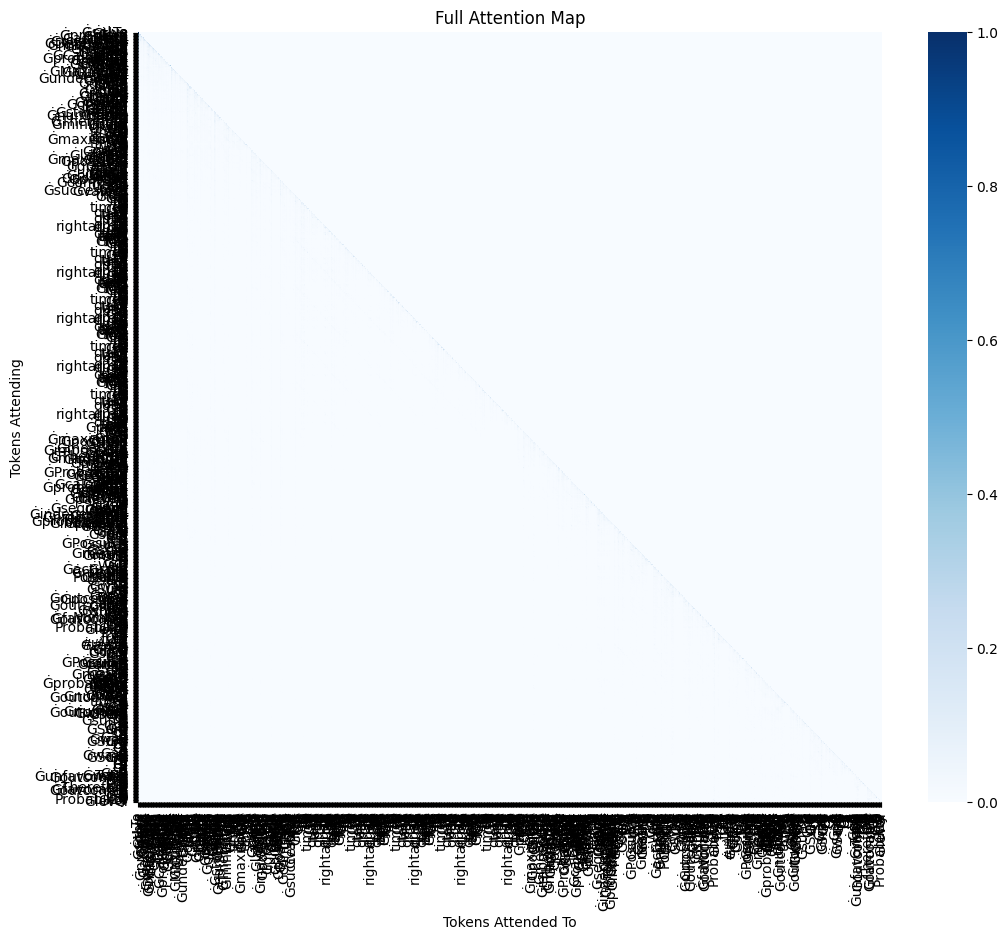

In [9]:
# Extract last layer attention
# attn_matrix = attentions[-1].mean(dim=0).cpu().numpy()  # Average over heads
attn_matrix = attentions[-1].mean(dim=0).to(torch.float32).cpu().numpy()

# Convert token IDs to readable tokens
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

# Plot the full attention map
plot_full_attention_map(attn_matrix, tokens)


## Plotting Attention Map For Only Focus Tokens + Window

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import FixedLocator
import re
import nltk
from nltk.tokenize import sent_tokenize


def plot_attention_map_windowed(attn_matrix, tokens, focus_idx_start, focus_idx_end, window_size=10, reasoning_cue=None, save_path=None):
    """
    Plots the full attention heatmap where both axes contain the same tokens.
    """
    # print(attn_matrix)
    if reasoning_cue == None:
        start_idx = max(focus_idx_start, 0)

    else:
        start_idx = max(focus_idx_start - window_size, 0)
    end_idx = min(focus_idx_end + window_size + 1, len(tokens))

    print(len(attn_matrix), len(attn_matrix[0]))

    attn_matrix = attn_matrix[start_idx:end_idx, start_idx:end_idx]  # Extract windowed attention
    tokens = tokens[start_idx:end_idx]

    plt.figure(figsize=(10, 10))  # Adjust figure size
    ax = sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=False)


    # # Get relative positions of focus indices in the windowed view
    focus_start_rel = focus_idx_start - start_idx
    focus_end_rel = focus_idx_end - start_idx

     # Create rectangle to highlight focus area - properly aligned with cell boundaries
    rect_x = focus_start_rel
    rect_y = focus_start_rel
    width = focus_end_rel - focus_start_rel + 1
    height = focus_end_rel - focus_start_rel + 1
    
    # Column highlight (vertical)
    column_rect = plt.Rectangle((rect_x, 0), width, len(tokens), 
                              linewidth=.5, edgecolor='red', facecolor='none')
    # Row highlight (horizontal)
    row_rect = plt.Rectangle((0, rect_y), len(tokens), height, 
                            linewidth=.5, edgecolor='red', facecolor='none')
    
    # Focus area intersection
    focus_rect = plt.Rectangle((rect_x, rect_y), width, height, 
                              linewidth=.5, edgecolor='darkred', facecolor='none', linestyle='--')


    if reasoning_cue != None:
        # Add rectangles to the plot
        ax.add_patch(column_rect)
        ax.add_patch(row_rect)
        ax.add_patch(focus_rect)
 
    
    plt.title("Full Attention Map")
    plt.xlabel("Tokens Attended To")
    plt.ylabel("Tokens Attending")
    # plt.xticks(rotation=90)
    # plt.yticks(rotation=0)

    plt.xticks(rotation=90, fontsize=6)  # Reduce font size for x-ticks
    plt.yticks(rotation=0, fontsize=6)  # Reduce font size for y-ticks

    # Save the figure if a path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directories if they don’t exist
        plt.savefig(save_path, dpi=300, bbox_inches="tight")  # Save with high quality

    plt.show()


def find_cue_indices(tokenizer, input_text, cue):
     # Tokenize while keeping track of character mapping
    encoding = tokenizer(input_text, return_tensors="pt", return_offsets_mapping=True)
    # print("ENCODING: ", encoding)
    # Convert token IDs to readable tokens
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

    
    if cue == None:
        sentences = sent_tokenize(input_text)
        if len(sentences) > 1:  # Ensure a second sentence exists
            second_sentence_start = input_text.find(sentences[1])  # Get character start index
            token_index = encoding.char_to_token(second_sentence_start)
            if token_index is not None:
                print(len(tokens), [(token_index, token_index)])
                return tokens, [(token_index, token_index)]
        return tokens, [(20,20)]

   
    # Find all occurrences of "Wait" in the original text
    # wait_char_indices = [m.start() for m in re.finditer(r'\bLet me reconsider\b', input_text)]
    regex_pattern = r'\b' + re.escape(cue) + r'\b'
    #The span() method of a regex match object returns tuple (start, end). start is inclusive, but end is exclusive.
    cue_char_span = [m.span() for m in re.finditer(regex_pattern, input_text)]
    cue_char_span = [(start, end-1) for start, end in cue_char_span]
    print("cue_char_indices", cue_char_span)
    
    # Get the token indices corresponding to each occurrence of "Wait"
    # wait_token_indices = [encoding.char_to_token(idx) for idx in wait_char_indices]
    cue_token_indices = [(encoding.char_to_token(start_idx), encoding.char_to_token(end_idx)) for start_idx, end_idx in cue_char_span]
    return tokens, cue_token_indices

def clean_tokens(tokens):
    """
    Cleans tokenizer output to make it more readable **without changing the token count**.
    
    1. Removes the 'Ġ' prefix (space marker) **but keeps words separate**.
    2. Replaces 'Ċ' (newline marker) with a visible symbol.
    3. Keeps all tokens intact without merging subwords.
    
    Parameters:
    tokens -- List of tokens from the tokenizer
    
    Returns:
    list -- Cleaned tokens for better readability **without modifying indices**.
    """
    cleaned_tokens = []
    
    for token in tokens:
        # Replace space markers but keep separate tokens
        cleaned = token.replace('Ġ', '')  # Remove space marker, but keep as a separate token
        cleaned = cleaned.replace('Ċ', '↵')  # Replace newlines with a visual marker

        cleaned_tokens.append(cleaned)  # Keep same token positions
    
    return cleaned_tokens


1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(234, 238), (389, 393)]
Processing UUID: 586fd646-76d6-5070-8c81-9993ab9d8559, Cue: First
Cue Indices: [(63, 63), (105, 105)]
Focus Index Start: 63, End: 63
attn_matrix 1024
Reduced attention shape: (972, 972)
972 972


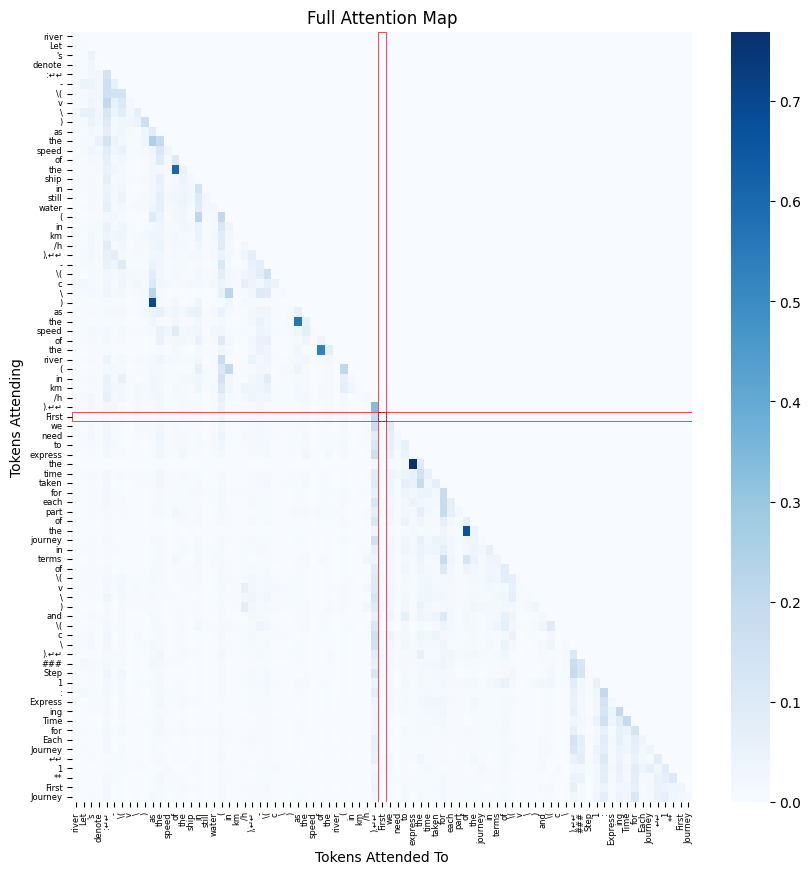

Focus Index Start: 105, End: 105
attn_matrix 1024
Reduced attention shape: (972, 972)
972 972


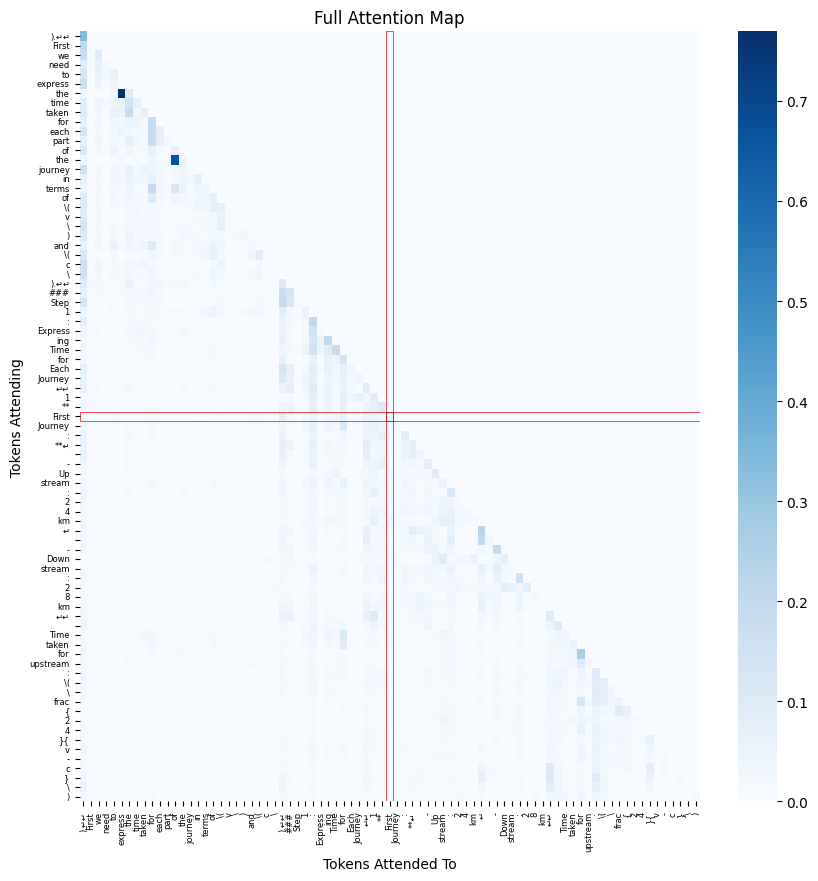

1 40
attentions shape:  (1, 40, 812, 812)
(812, 812)
cue_char_indices [(778, 786), (1956, 1964)]
Processing UUID: 1d57f4b3-c516-5522-91cc-a60dd91f6f66, Cue: Therefore
Cue Indices: [(195, 195), (770, 770)]
Focus Index Start: 195, End: 195
attn_matrix 812
Reduced attention shape: (757, 757)
757 757


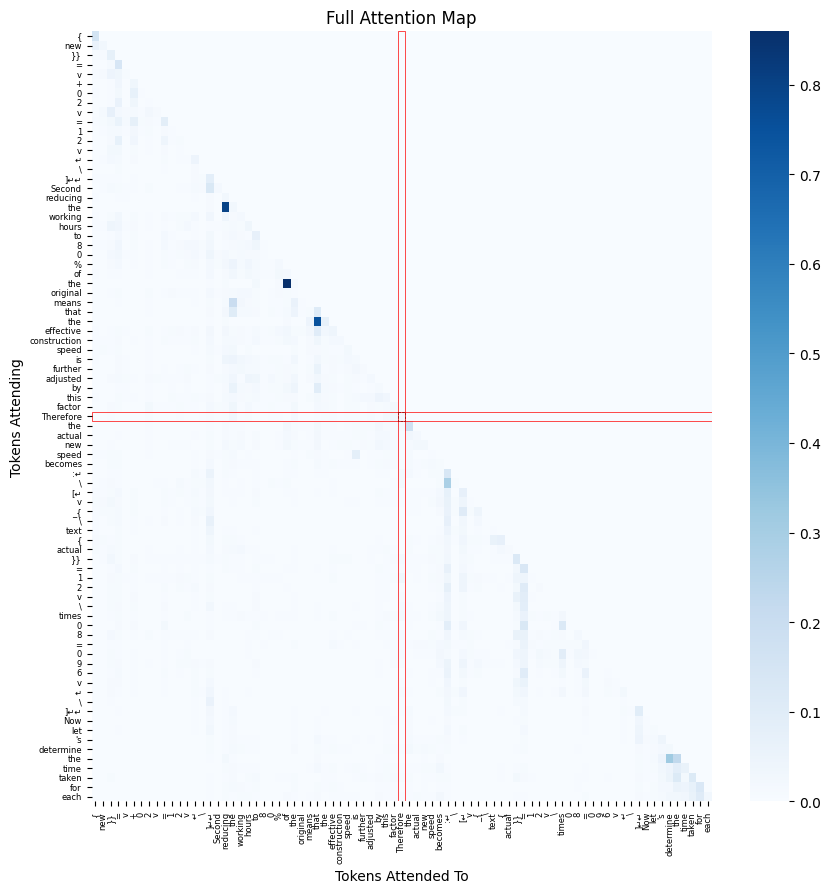

Focus Index Start: 770, End: 770
attn_matrix 812
Reduced attention shape: (757, 757)
757 757


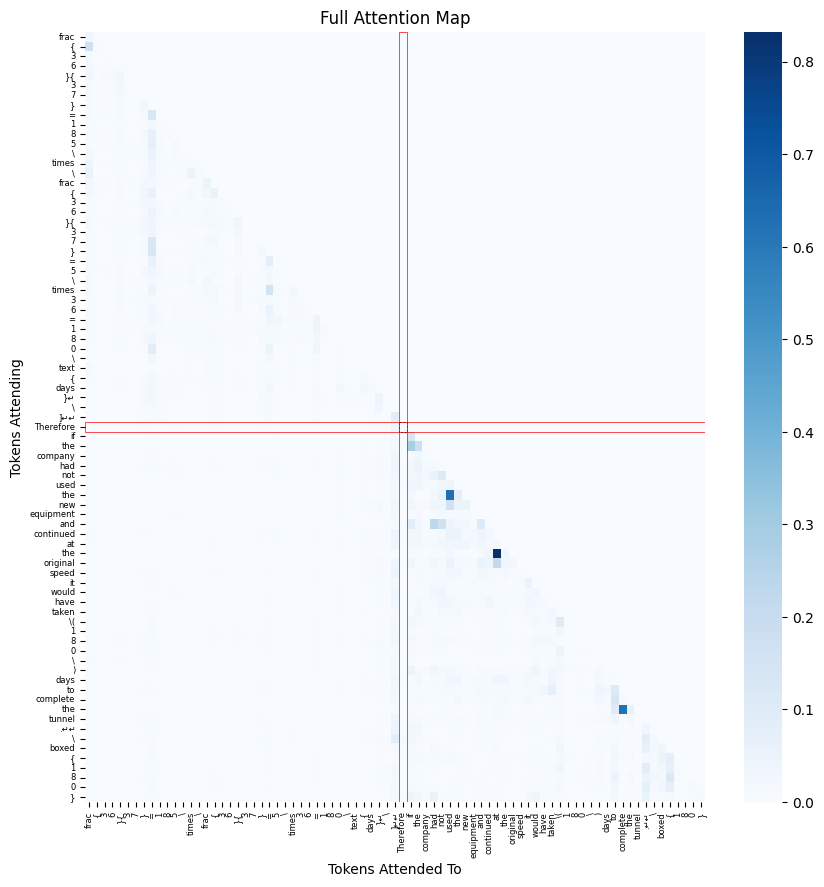

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(394, 397), (813, 816), (1499, 1502), (1797, 1800), (2129, 2132)]
Processing UUID: 84f224e8-719b-5b42-a410-27816014bdd3, Cue: Thus
Cue Indices: [(136, 136), (321, 321), (640, 640), (782, 782), (931, 931)]
Focus Index Start: 136, End: 136
attn_matrix 1024
Reduced attention shape: (988, 988)
988 988


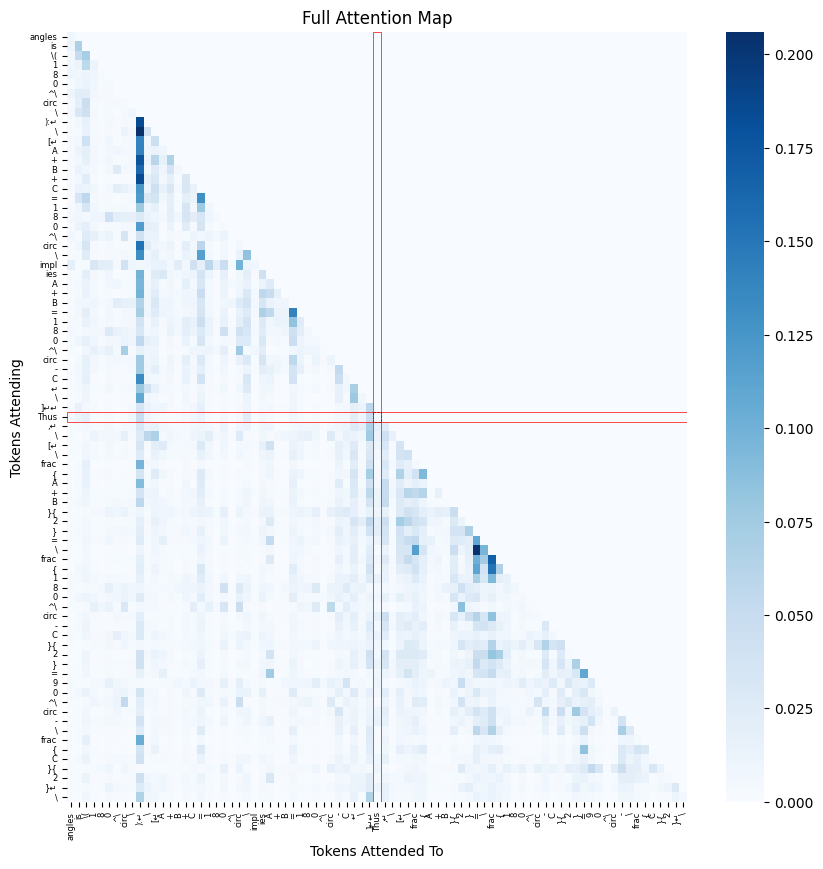

Focus Index Start: 321, End: 321
attn_matrix 1024
Reduced attention shape: (988, 988)
988 988


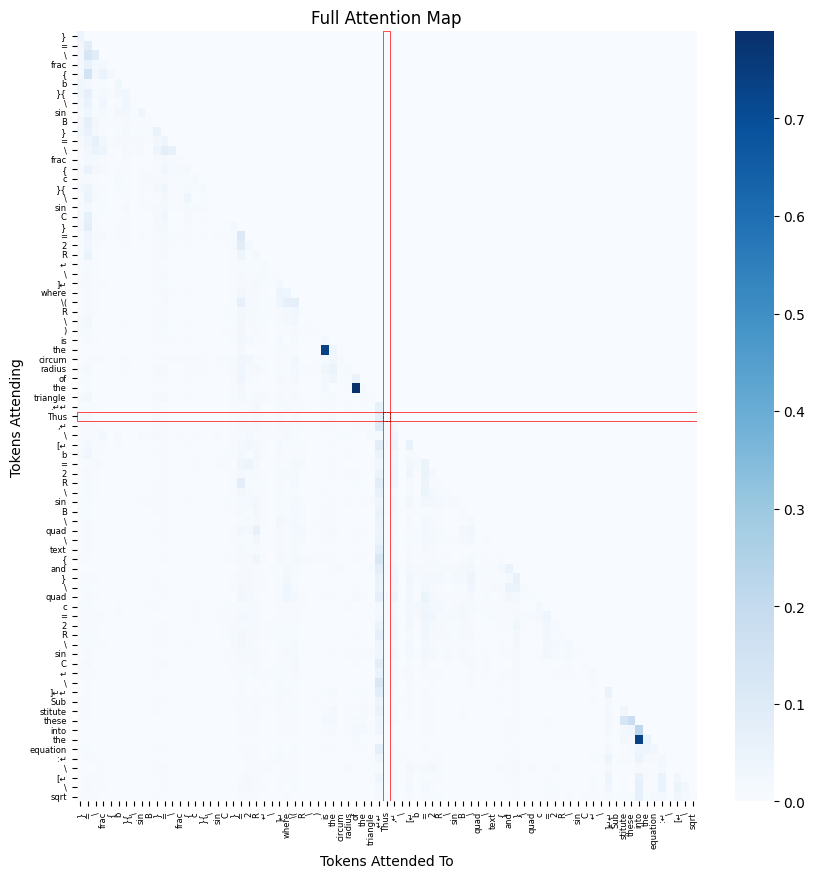

Focus Index Start: 640, End: 640
attn_matrix 1024
Reduced attention shape: (988, 988)
988 988


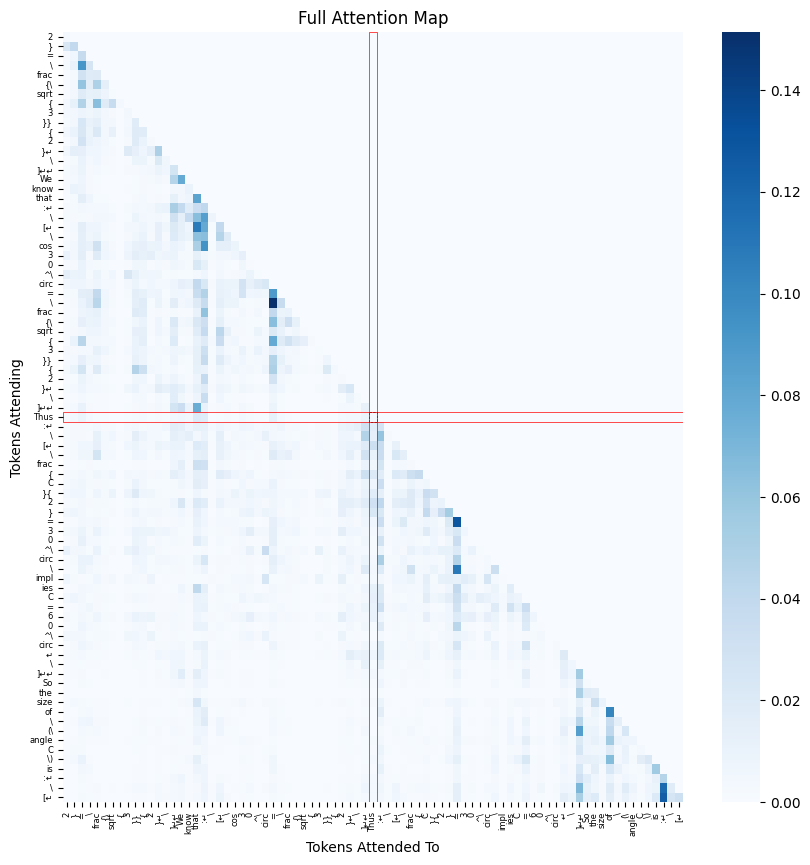

Focus Index Start: 782, End: 782
attn_matrix 1024
Reduced attention shape: (988, 988)
988 988


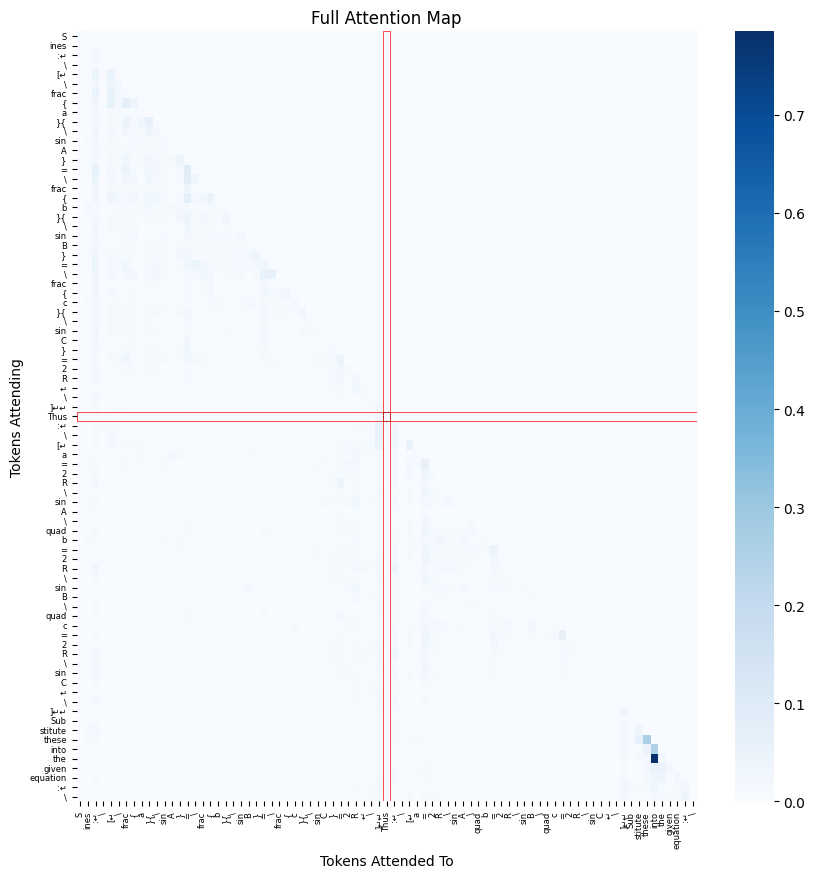

Focus Index Start: 931, End: 931
attn_matrix 1024
Reduced attention shape: (988, 988)
988 988


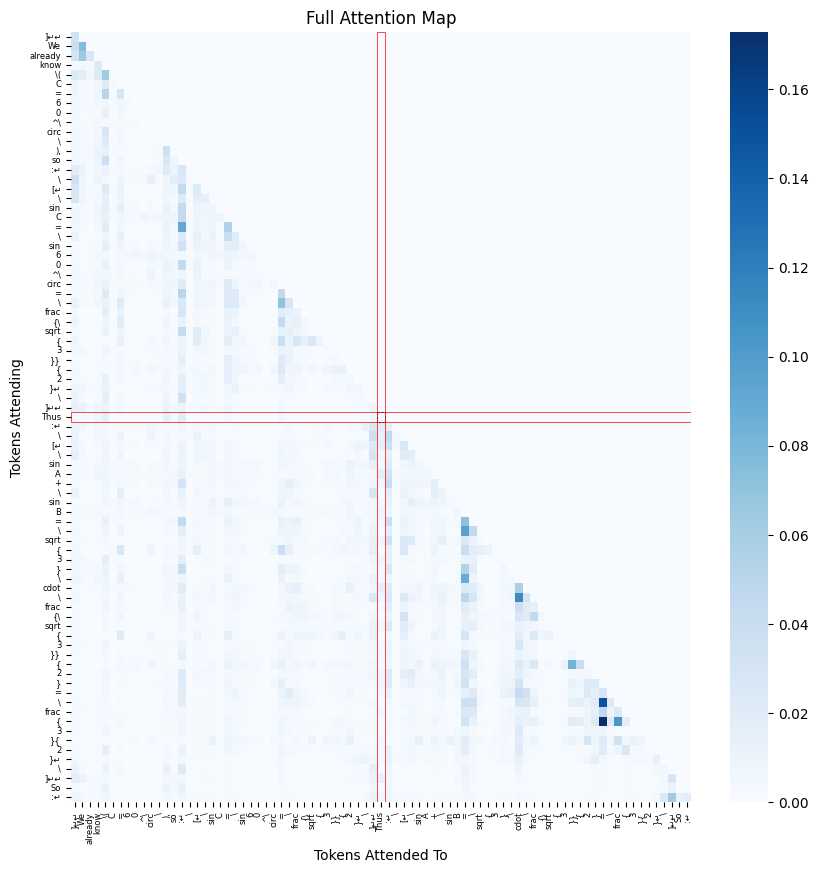

1 40
attentions shape:  (1, 40, 1023, 1023)
(1023, 1023)
cue_char_indices [(2163, 2166)]
Processing UUID: 96c9bf5f-cffe-505b-80c0-e679e10d2cf9, Cue: Wait
Cue Indices: [(710, 710)]
Focus Index Start: 710, End: 710
attn_matrix 1023
Reduced attention shape: (867, 867)
867 867


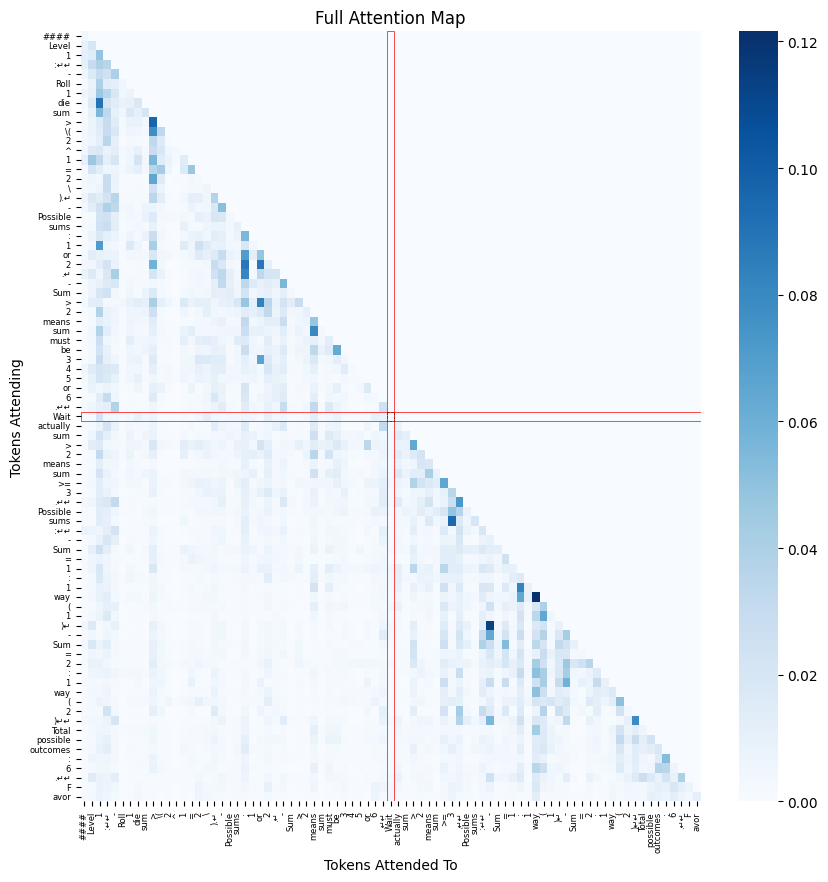

1 40
attentions shape:  (1, 40, 1023, 1023)
(1023, 1023)
cue_char_indices []
Processing UUID: e93a8cbd-336b-5aa7-9e39-b81d5037510d, Cue: approximate
Cue Indices: []
1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(2355, 2371), (3527, 3543)]
Processing UUID: 05c6feba-c571-5253-9e7a-a43d0032fefc, Cue: a better approach
Cue Indices: [(619, 621), (1012, 1014)]
Focus Index Start: 619, End: 621
attn_matrix 1024
Reduced attention shape: (941, 941)
941 941


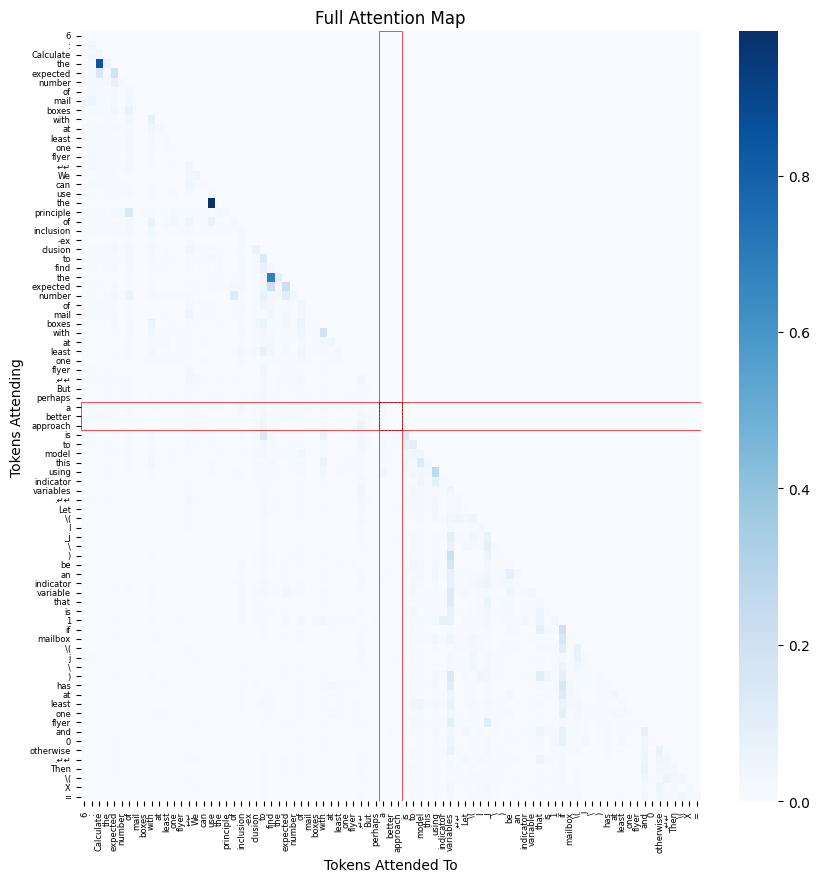

Focus Index Start: 1012, End: 1014
attn_matrix 1024
Reduced attention shape: (941, 941)
941 941


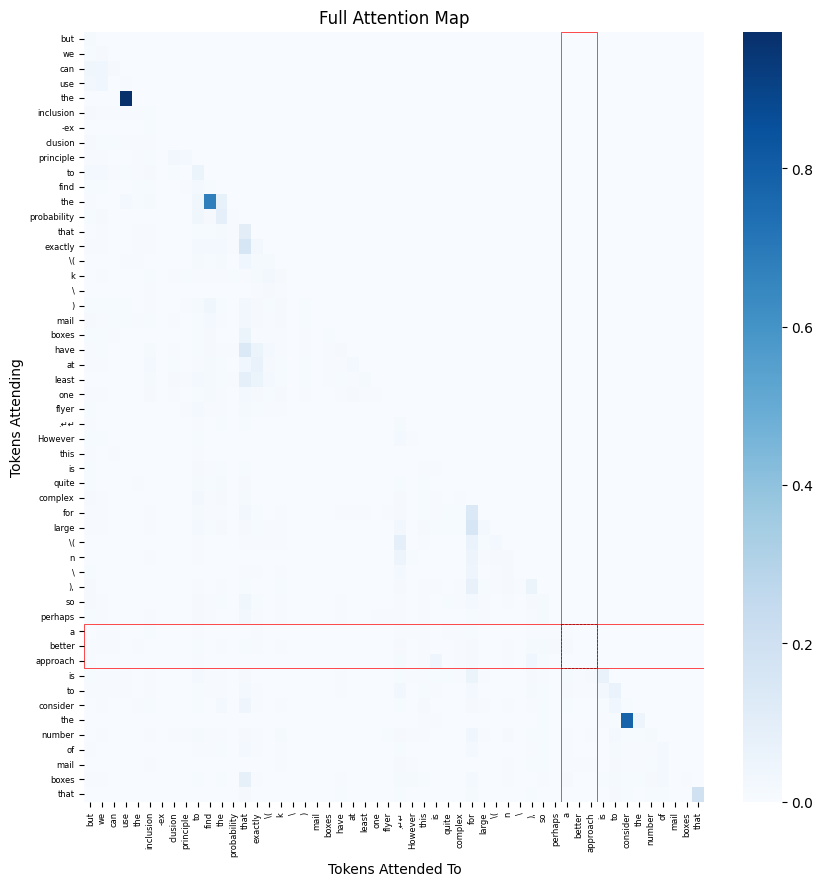

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(423, 426), (1833, 1836), (3704, 3707)]
Processing UUID: a62b9e76-5993-59bd-81e5-342b61459c26, Cue: Then
Cue Indices: [(100, 100), (471, 471), (902, 902)]
Focus Index Start: 100, End: 100
attn_matrix 1024
Reduced attention shape: (947, 947)
947 947


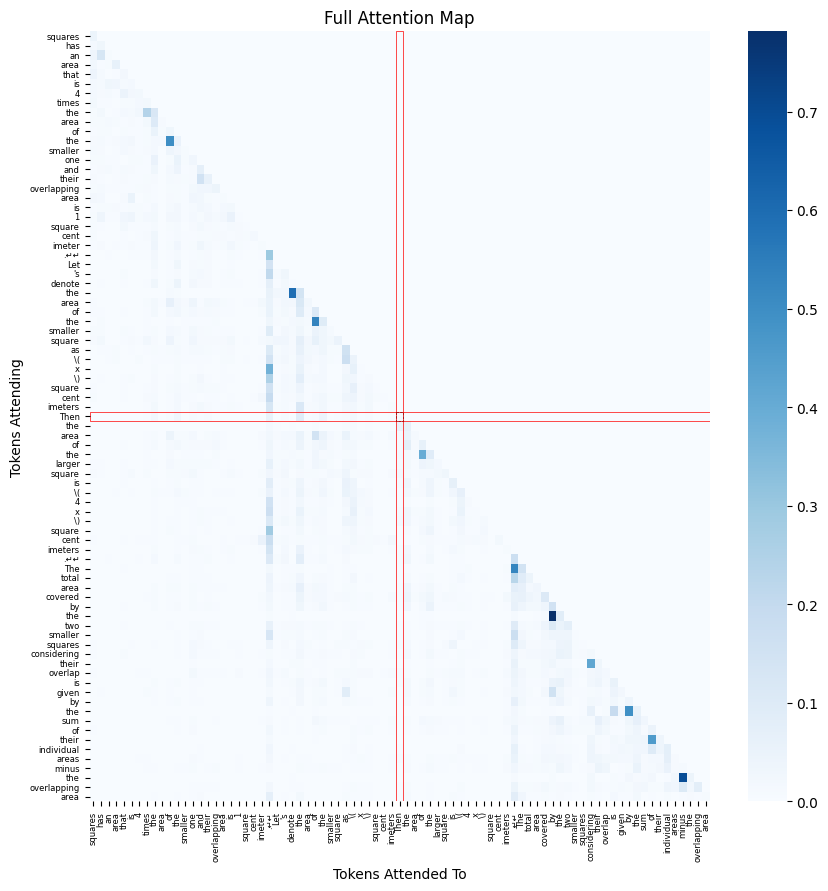

Focus Index Start: 471, End: 471
attn_matrix 1024
Reduced attention shape: (947, 947)
947 947


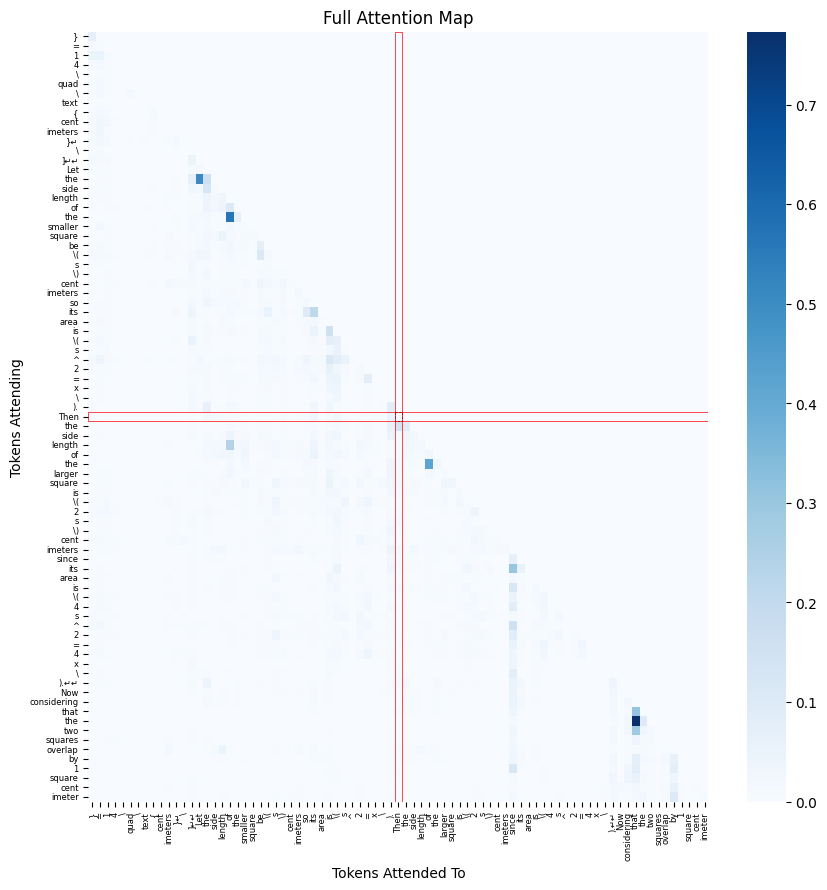

Focus Index Start: 902, End: 902
attn_matrix 1024
Reduced attention shape: (947, 947)
947 947


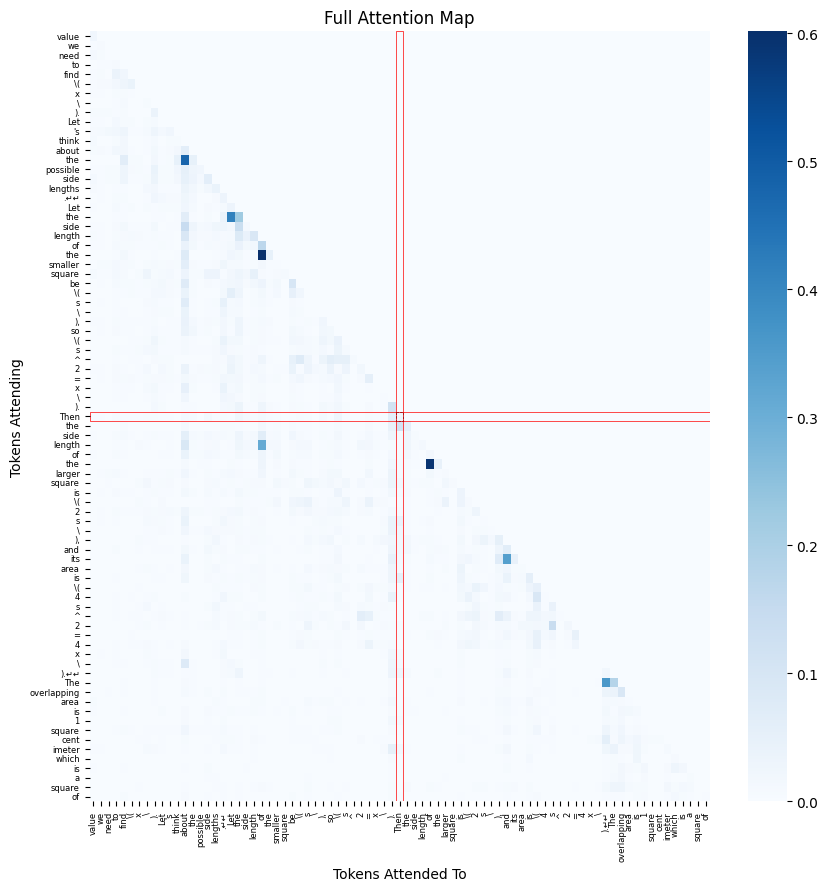

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(2126, 2143)]
Processing UUID: 33d55892-4916-5da3-a46d-d4c242e74b6b, Cue: This simplifies to
Cue Indices: [(865, 868)]
Focus Index Start: 865, End: 868
attn_matrix 1024
Reduced attention shape: (961, 961)
961 961


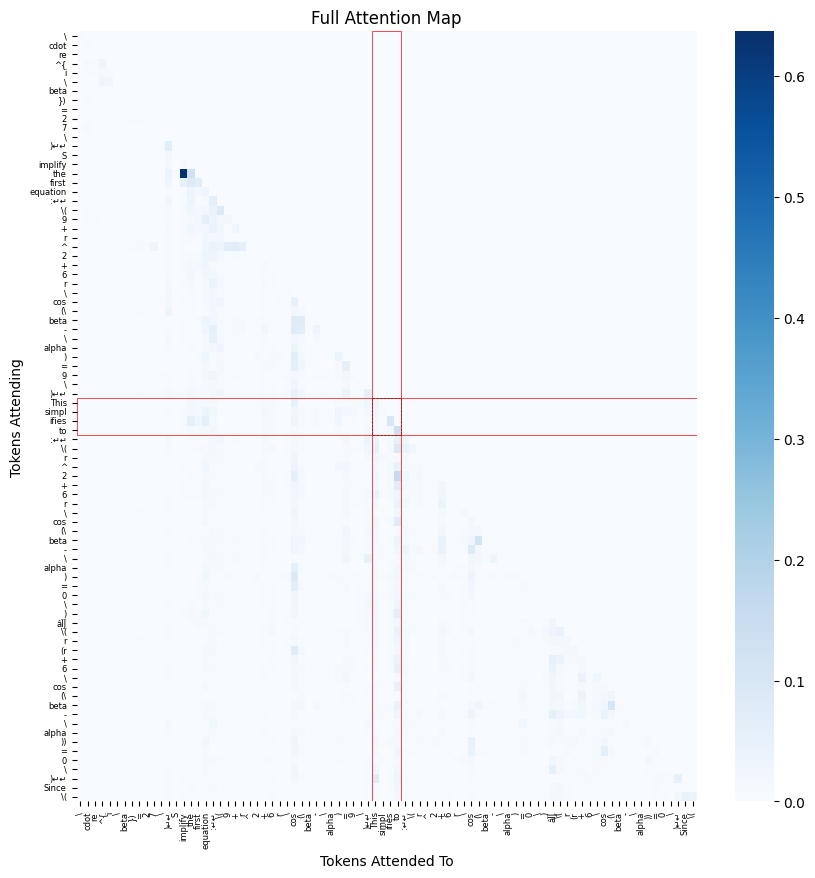

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(461, 472)]
Processing UUID: 986c0e87-ff9d-53be-8035-c9ef57638b9e, Cue: This implies
Cue Indices: [(122, 123)]
Focus Index Start: 122, End: 123
attn_matrix 1024
Reduced attention shape: (944, 944)
944 944


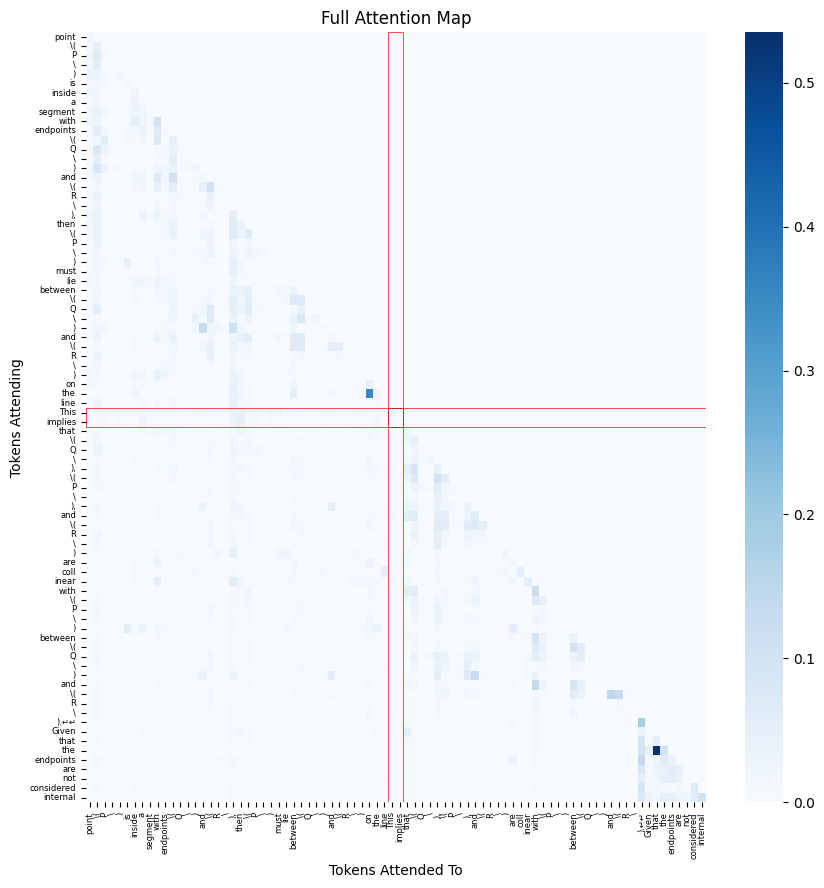

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(924, 932)]
Processing UUID: 2eb4e013-b730-5f3f-bbad-8f472adff0fb, Cue: incorrect
Cue Indices: [(377, 377)]
Focus Index Start: 377, End: 377
attn_matrix 1024
Reduced attention shape: (987, 987)
987 987


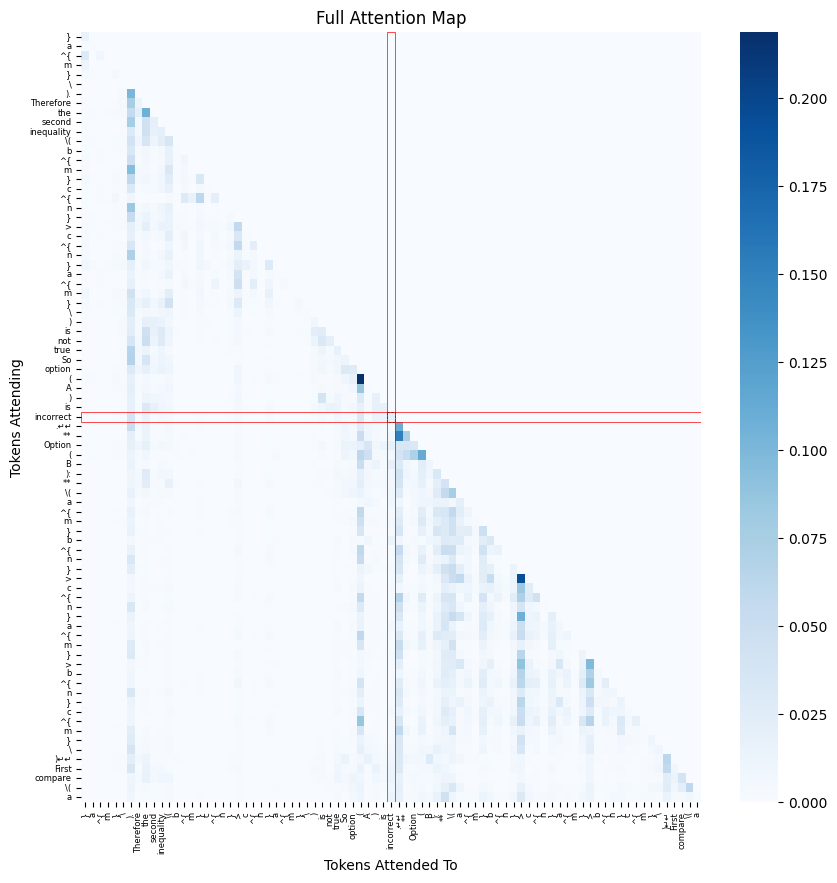

1 40
attentions shape:  (1, 40, 393, 393)
(393, 393)
cue_char_indices [(999, 1005)]
Processing UUID: d9393712-4479-572a-8e7c-964aae52eeea, Cue: Finally
Cue Indices: [(339, 339)]
Focus Index Start: 339, End: 339
attn_matrix 393
Reduced attention shape: (350, 350)
350 350


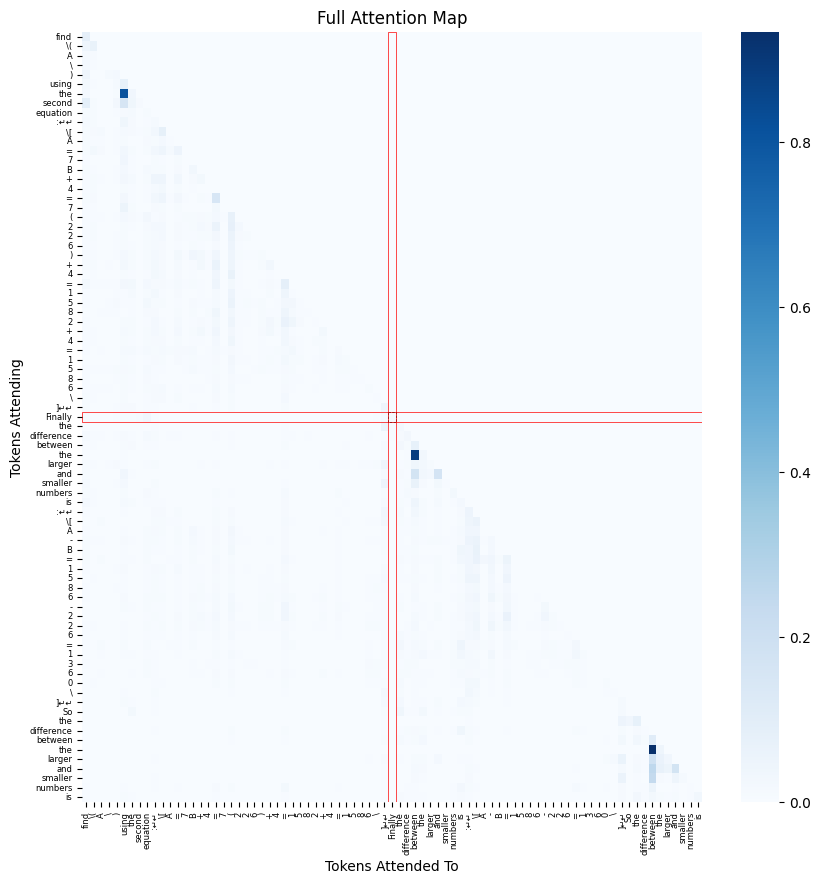

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(2543, 2547)]
Processing UUID: b6c28d81-0bbd-531c-a7d7-fa08eb1a16c1, Cue: maybe
Cue Indices: [(835, 835)]
Focus Index Start: 835, End: 835
attn_matrix 1024
Reduced attention shape: (863, 863)
863 863


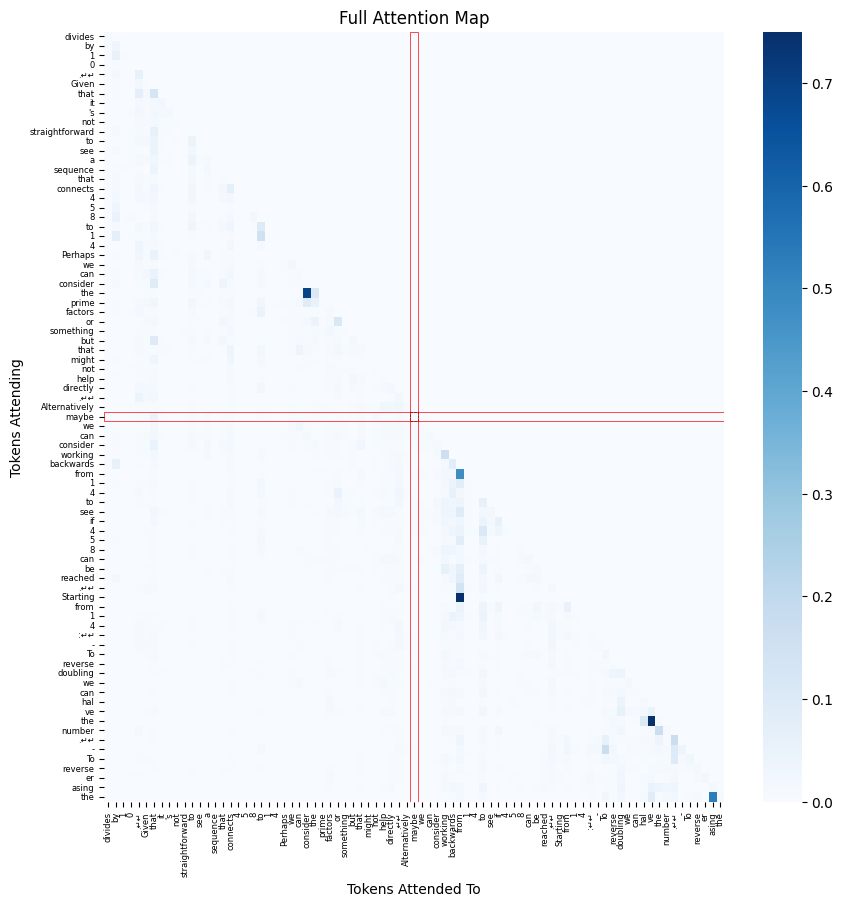

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(1396, 1399)]
Processing UUID: 3135dae5-2b21-52bc-83ce-9bfc1e35a7d8, Cue: Next
Cue Indices: [(592, 592)]
Focus Index Start: 592, End: 592
attn_matrix 1024
Reduced attention shape: (899, 899)
899 899


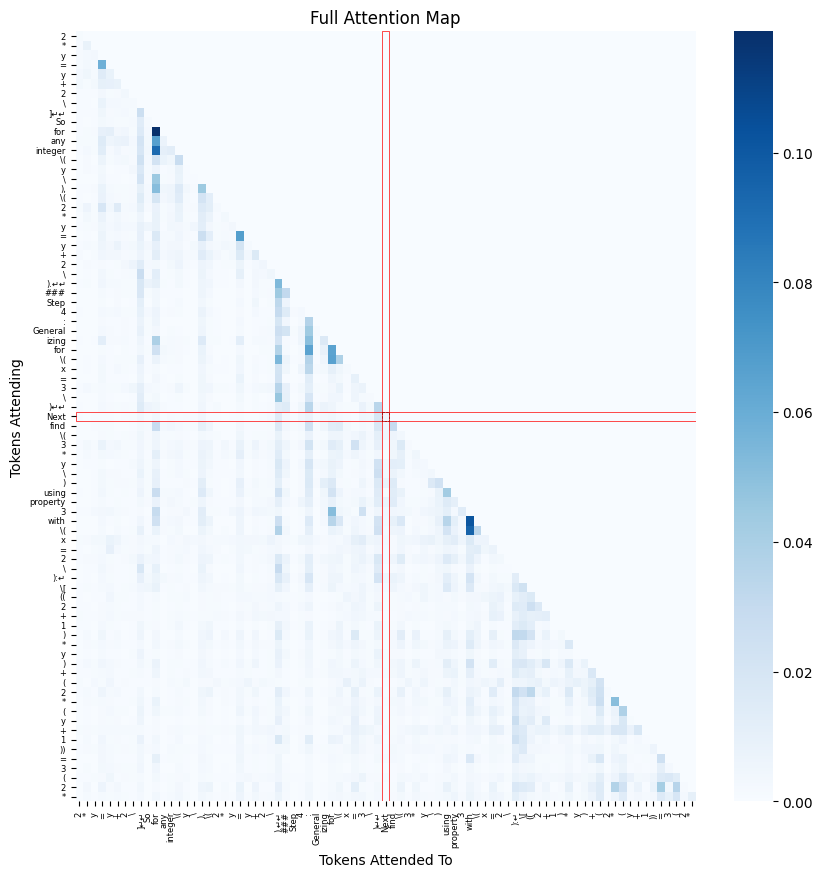

1 40
attentions shape:  (1, 40, 1024, 1024)
(1024, 1024)
cue_char_indices [(3601, 3605)]
Processing UUID: 7604c2de-1b30-5600-a8ec-30ed835b2e04, Cue: Hence
Cue Indices: [(1022, 1022)]
Focus Index Start: 1022, End: 1022
attn_matrix 1024
Reduced attention shape: (950, 950)
950 950


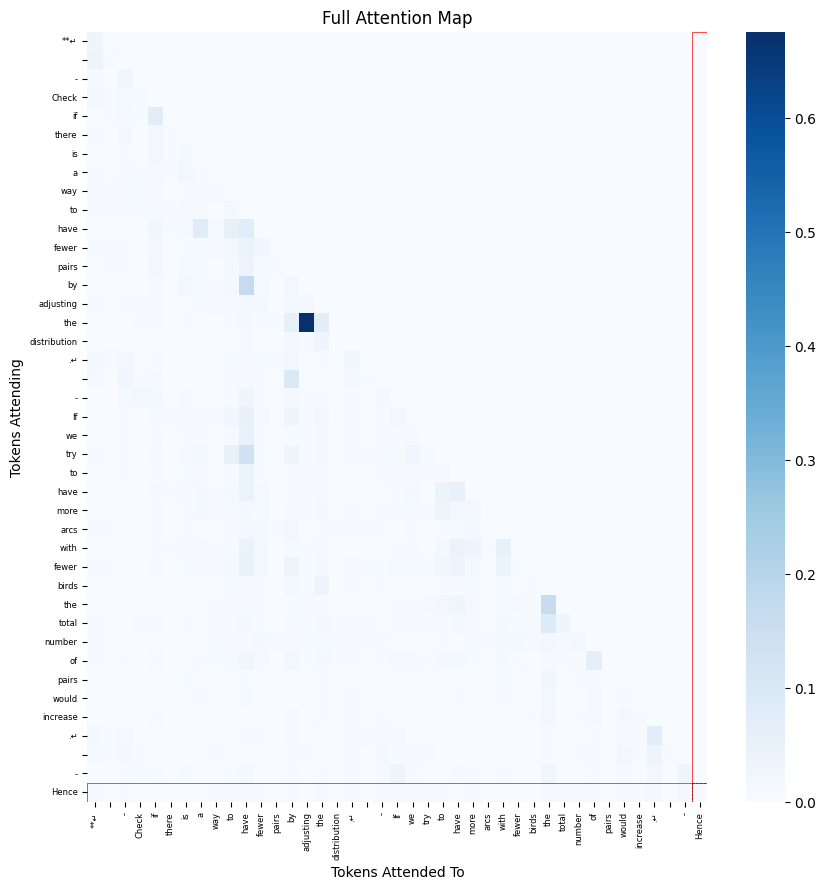

In [34]:
import os
# Iterate through each sampled example
for idx, row in sampled_df.iterrows():
    # row = df.iloc[0]  # Get the first row
    
    # Access values from the first row
    reasoning_key = row["cot_reasoning_key"]
    reasoning_value = row["cot_reasoning_value"]
    uuid = row["uuid"]
    input_text = row["model_response"]
    
    # print(reasoning_key, reasoning_value, uuid, input_text)
    
    
    # Tokenize and get model outputs
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True, return_dict=True)
    
    # Extract attention maps from last layer
    attentions = outputs.attentions[-1]  # Last layer attention
    attentions = attentions.cpu().to(torch.float32).numpy()
    print(len(attentions), len(attentions[0]))
    print("attentions shape: ", np.shape(attentions))
    # attn_matrix = attentions[0].mean(axis=0)  # Average over all heads, shape: (1024, 1024)
    # attn_matrix = attn_matrix[0]
    attn_matrix = attentions[0, 0]  # [batch_idx, head_idx, seq_len, seq_len]
    print(np.shape(attn_matrix))
    
    
    # Define cue
    cue = reasoning_value if pd.notna(reasoning_value) else None
    tokens, cue_indices = find_cue_indices(tokenizer, input_text, cue)
    
    
    print(f"Processing UUID: {uuid}, Cue: {cue}")
    print("Cue Indices:", cue_indices)
    
    for focus_idx_start, focus_idx_end in cue_indices:
        print(f"Focus Index Start: {focus_idx_start}, End: {focus_idx_end}")
    
        # Remove unwanted tokens & update the focus index
        reduced_attn_matrix, reduced_tokens, new_focus_idx_start, new_focus_idx_end = remove_unwanted_tokens(
            tokens, attn_matrix, focus_idx_start, focus_idx_end
        )
    
        # Clean tokens for visualization
        cleaned_tokens = clean_tokens(reduced_tokens)
    
        # Define save path
        save_dir = os.path.join("attention_maps", reasoning_key)
        os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists
        save_path = os.path.join(save_dir, f"{uuid}_{reasoning_value}.png")
    
        # Plot and save attention map
        plot_attention_map_windowed(
            reduced_attn_matrix, 
            cleaned_tokens, 
            new_focus_idx_start, 
            new_focus_idx_end, 
            window_size=40, 
            reasoning_cue=cue, 
            save_path=save_path
        )
           


In [13]:
## attention grid

In [42]:
def remove_unwanted_tokens(tokens, attn_matrix, focus_idx_start, focus_idx_end):
    """
    Removes unwanted tokens and updates the focus index accordingly.
    Returns the new attention matrix, reduced token list, and updated focus index.
    """
    print("attn_matrix", len(attn_matrix))
    print("original token in cue", tokens[focus_idx_start])
    unwanted_tokens = {"", " ", "Ġ", "G", '"', "'", ",", ".", "!", "?", "<pad>", "<s>", "</s>"}

    # Identify valid tokens
    valid_indices = [i for i, token in enumerate(tokens) if token not in unwanted_tokens]
    
    # Create a mapping: old index → new index
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_indices)}

    # Update focus index
    new_focus_idx_start = index_mapping.get(focus_idx_start, None)  # None if focus token got removed
    new_focus_idx_end = index_mapping.get(focus_idx_end, None)  # None if focus token got removed

    # Reduce the attention matrix & tokens list
    # reduced_attn_matrix = attn_matrix[np.ix_(valid_indices, valid_indices)]
    reduced_tokens = [tokens[i] for i in valid_indices]
    print("new token in cue", reduced_tokens[new_focus_idx_start])


    # Move attn_matrix to CPU and convert to NumPy if it's a tensor
    if isinstance(attn_matrix, torch.Tensor):
        attn_matrix = attn_matrix.to(torch.float32).cpu().numpy()  # Convert to float32 before NumPy

        
    # **Handle Multi-Head Attention Case**
    if len(attn_matrix.shape) == 3:  
        print("here") # (num_heads, seq_len, seq_len)
        num_heads = attn_matrix.shape[0]
        reduced_attn_matrix = np.zeros((num_heads, len(valid_indices), len(valid_indices)))

        for head in range(num_heads):
            reduced_attn_matrix[head] = attn_matrix[head][np.ix_(valid_indices, valid_indices)]
    
    # **Handle Single-Head Attention Case**
    elif len(attn_matrix.shape) == 2:  # (seq_len, seq_len)
        reduced_attn_matrix = attn_matrix[np.ix_(valid_indices, valid_indices)]

    else:
        raise ValueError(f"Unexpected attention matrix shape: {attn_matrix.shape}")

    print(f"Reduced attention shape: {reduced_attn_matrix.shape}")
    
    return reduced_attn_matrix, reduced_tokens, new_focus_idx_start, new_focus_idx_end




def plot_attention_grid(attentions, tokens, focus_idx_start, focus_idx_end, window_size=10, 
                        reasoning_cue=None, save_path=None, grid_rows=6, grid_cols=7, title = "No Title"):
    """
    Plot attention maps for all heads in a grid layout.
    
    Args:
        attentions: Full attention tensor of shape [ num_heads, seq_len, seq_len]
        tokens: List of tokens
        focus_idx_start: Start index of focus region
        focus_idx_end: End index of focus region
        window_size: Size of window around focus region
        reasoning_cue: Cue being highlighted
        save_path: Path to save the figure
        grid_rows: Number of rows in the grid
        grid_cols: Number of columns in the grid
    """
    print("FUNC: ", "plot_attention_grid")
    # Extract dimensions
    num_heads, seq_len, _ = attentions.shape
    print('start, end', focus_idx_start, focus_idx_end)


    if reasoning_cue is None:
        start_idx = max(focus_idx_start, 0)
    else:
        start_idx = max(focus_idx_start - window_size, 0)
    
    # Ensure end_idx does not exceed valid range
    end_idx = min(focus_idx_end + window_size + 1, len(tokens) - 1)
    
    # If start_idx == end_idx, force an expansion
    if start_idx >= end_idx:
        print(f"Warning: start_idx ({start_idx}) and end_idx ({end_idx}) are the same! Expanding window.")
        end_idx = min(start_idx + 1, len(tokens) - 1)
    
    print(f"Adjusted window indices: start {start_idx}, end {end_idx}")


    # attn_matrix = attn_matrix[start_idx:end_idx, start_idx:end_idx]  # Extract windowed attention
    window_tokens = tokens[start_idx:end_idx]

    # Extract the windowed attention matrix
    windowed_attn = attentions[:, start_idx:end_idx + 1, start_idx:end_idx + 1]  # Apply windowing to all heads
    print(f"Windowed Attention Shape: {windowed_attn.shape}")

    
    # Create a large figure for the grid
    fig = plt.figure(figsize=(grid_cols * 4, grid_rows * 4))
    
    # Create GridSpec for more control over subplot layout
    # gs = gridspec.GridSpec(grid_rows, grid_cols, figure=fig, wspace=0.3, hspace=0.3)
    gs = gridspec.GridSpec(grid_rows, grid_cols, figure=fig, wspace=0.1, hspace=0.1)  

    # # Determine relative focus positions in windowed view
    focus_start_rel = max(0, focus_idx_start - start_idx)
    focus_end_rel = min(end_idx - start_idx - 1, focus_idx_end - start_idx)



    print(f"window_tokens ({len(window_tokens)}):", window_tokens)
    print(f"focus_start_rel: {focus_start_rel}, focus_end_rel: {focus_end_rel}")

    # Plot each head's attention map
    for head_idx in range(min(num_heads, grid_rows * grid_cols)):
        # Calculate grid position
        row = head_idx // grid_cols
        col = head_idx % grid_cols
        
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        
        # Get this head's attention matrix and apply windowing
        head_attn = attentions[head_idx]  # [batch_idx, head_idx, seq_len, seq_len]
        windowed_attn = head_attn[start_idx:end_idx, start_idx:end_idx]
        
        # Plot heatmap
        # Use very small or no labels based on number of tokens
        should_label = len(window_tokens) <= 15  # Only show labels if few tokens
        
        if should_label:
            sns.heatmap(windowed_attn, cmap="Blues", annot=False, 
                        xticklabels=window_tokens, yticklabels=window_tokens, ax=ax)
        else:
            sns.heatmap(windowed_attn, cmap="Blues", annot=False, 
                        xticklabels=False, yticklabels=False, ax=ax)
        
        # Calculate rectangle coordinates for focus highlighting
        rect_x = focus_start_rel
        rect_y = focus_start_rel
        width = focus_end_rel - focus_start_rel + 1
        height = focus_end_rel - focus_start_rel + 1
        
        if reasoning_cue is not None and width > 0 and height > 0:
            # Column highlight (vertical)
            column_rect = plt.Rectangle((rect_x, 0), width, len(window_tokens), 
                                      linewidth=0.5, edgecolor='red', facecolor='none')
            # Row highlight (horizontal)
            row_rect = plt.Rectangle((0, rect_y), len(window_tokens), height, 
                                    linewidth=0.5, edgecolor='red', facecolor='none')
            # Focus area intersection
            focus_rect = plt.Rectangle((rect_x, rect_y), width, height, 
                                      linewidth=0.5, edgecolor='darkred', facecolor='none', 
                                      linestyle='--')
            
            ax.add_patch(column_rect)
            ax.add_patch(row_rect)
            ax.add_patch(focus_rect)
        
        # Set title and minimal labeling for grid clarity
        ax.set_title(f"Head {head_idx}", fontsize=10)



    # Add overall title
    # cue_display = reasoning_cue if reasoning_cue else "Unknown Cue"
    plt.suptitle(title, fontsize=16)
    
    # Add single X and Y labels for the whole figure
    fig.text(0.5, 0.01, "Tokens Attending", ha="center", fontsize=14)  # Move X label closer
    fig.text(0.01, 0.5, "Tokens Attended To", va="center", rotation="vertical", fontsize=14)  # Move Y label closer

    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
    
    # Save figure if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved to {save_path}")
    
    plt.show()
    
    return fig





  
def plot_attention_grid_pretty(attentions, tokens, focus_idx_start, focus_idx_end, window_size=10, 
                        reasoning_cue=None, save_path=None, grid_rows=6, grid_cols=7, title="No Title"):
    """
    Plot attention maps for all heads in a grid layout with enhanced visualization.
    
    Args:
        attentions: Attention tensor of shape [num_heads, seq_len, seq_len]
        tokens: List of tokens
        focus_idx_start: Start index of focus region
        focus_idx_end: End index of focus region
        window_size: Size of window around focus region
        reasoning_cue: Cue being highlighted
        save_path: Path to save the figure
        grid_rows: Number of rows in the grid
        grid_cols: Number of columns in the grid
        title: Title for the entire figure
    """
    # Extract dimensions
    num_heads, seq_len, _ = attentions.shape
    print(f"Input attention shape: {attentions.shape}")
    print(f"Focus indices: {focus_idx_start}, {focus_idx_end}")

    # Determine window bounds with better handling of edge cases
    if reasoning_cue is None:
        start_idx = max(focus_idx_start, 0)
    else:
        start_idx = max(focus_idx_start - window_size, 0)
    
    # Ensure end_idx does not exceed valid range
    end_idx = min(focus_idx_end + window_size + 1, len(tokens))
    
    # If start_idx >= end_idx, force an expansion
    if start_idx >= end_idx - 1:
        print(f"Warning: start_idx ({start_idx}) is too close to end_idx ({end_idx})! Expanding window.")
        if end_idx < len(tokens) - 5:
            end_idx = min(end_idx + 5, len(tokens))
        else:
            start_idx = max(start_idx - 5, 0)
    
    print(f"Window indices: start {start_idx}, end {end_idx}")

    # Extract the window tokens and determine relative focus positions
    window_tokens = tokens[start_idx:end_idx]
    focus_start_rel = max(0, focus_idx_start - start_idx)
    focus_end_rel = min(end_idx - start_idx - 1, focus_idx_end - start_idx)
    
    print(f"Relative focus position: {focus_start_rel}, {focus_end_rel}")
    print(f"Window size: {len(window_tokens)} tokens")

    # Find global min and max values for consistent color scaling
    global_min = np.inf
    global_max = -np.inf
    
    for head_idx in range(min(num_heads, grid_rows * grid_cols)):
        head_attn = attentions[head_idx]
        windowed_attn = head_attn[start_idx:end_idx, start_idx:end_idx]
        global_min = min(global_min, windowed_attn.min())
        global_max = max(global_max, windowed_attn.max())

    # Adjust max to prevent domination by outliers (cap at 95th percentile if there are outliers)
    all_values = attentions[:, start_idx:end_idx, start_idx:end_idx].flatten()
    percentile_95 = np.percentile(all_values, 95)
    if global_max > percentile_95 * 2:  # If max is much larger than 95th percentile
        global_max = percentile_95 * 1.5  # Use adjusted max
        print(f"Adjusting colormap max to {global_max:.4f} (95th percentile: {percentile_95:.4f})")
    
    # Create figure with more space for the colorbar
    fig = plt.figure(figsize=(grid_cols * 3.5 + 1, grid_rows * 3 + 0.5))
    
    # Create GridSpec with space for colorbar
    gs = gridspec.GridSpec(grid_rows, grid_cols + 1, figure=fig,
                          width_ratios=[1] * grid_cols + [0.1],  # Add column for colorbar
                          wspace=0.15, hspace=0.2)
    
    # Define a custom colormap for better visualization
    cmap = plt.cm.get_cmap('Blues')  # Base colormap
    
    # Track the heatmaps to create a shared colorbar
    heatmaps = []
    
    # Plot each head's attention map
    for head_idx in range(min(num_heads, grid_rows * grid_cols)):
        # Calculate grid position
        row = head_idx // grid_cols
        col = head_idx % grid_cols
        
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        
        # Get this head's attention matrix and apply windowing
        head_attn = attentions[head_idx]
        windowed_attn = head_attn[start_idx:end_idx, start_idx:end_idx]
        
        # Determine whether to show labels based on token count
        should_label = len(window_tokens) <= 15
        
        # Plot heatmap with consistent color scaling
        if should_label:
            hm = sns.heatmap(windowed_attn, cmap=cmap, annot=False, 
                          xticklabels=window_tokens, yticklabels=window_tokens, 
                          ax=ax, vmin=global_min, vmax=global_max, cbar=False)
        else:
            # For many tokens, show a sample of ticks (every nth token)
            n = max(1, len(window_tokens) // 5)  # Show about 5 ticks
            sample_indices = list(range(0, len(window_tokens), n))
            
            # Ensure the focus tokens are among the ticks
            if focus_start_rel not in sample_indices and focus_start_rel < len(window_tokens):
                sample_indices.append(focus_start_rel)
            if focus_end_rel not in sample_indices and focus_end_rel < len(window_tokens):
                sample_indices.append(focus_end_rel)
            
            sample_indices = sorted(sample_indices)
            sample_tokens = [window_tokens[i] for i in sample_indices]
            
            hm = sns.heatmap(windowed_attn, cmap=cmap, annot=False, 
                          xticklabels=sample_tokens if len(sample_tokens) <= 10 else False,
                          yticklabels=sample_tokens if len(sample_tokens) <= 10 else False,
                          ax=ax, vmin=global_min, vmax=global_max, cbar=False)
            
            # Set tick positions to match the sampled tokens
            if len(sample_tokens) <= 10:
                ax.set_xticks([i for i in sample_indices])
                ax.set_yticks([i for i in sample_indices])
        
        heatmaps.append(hm)
        
        # Highlight focus area if reasoning_cue is provided
        if reasoning_cue is not None and focus_start_rel <= focus_end_rel:
            # Print debug information
            print(f"Original focus positions: {focus_start_rel}, {focus_end_rel}")
            
            # In heatmap coordinates, cell positions are at the integer indices
            # Rectangles need to start at the integer position and have integer width/height
            rect_x = focus_start_rel
            rect_y = focus_start_rel
            width = focus_end_rel - focus_start_rel + 1
            height = focus_end_rel - focus_start_rel + 1
            
            print(f"Rectangle: x={rect_x}, y={rect_y}, w={width}, h={height}")
            
            # Column highlight (vertical)
            column_rect = plt.Rectangle((rect_x, 0), width, len(window_tokens),
                                      linewidth=1.0, edgecolor='red', facecolor='none', alpha=0.7)
            # Row highlight (horizontal)
            row_rect = plt.Rectangle((0, rect_y), len(window_tokens), height,
                                    linewidth=1.0, edgecolor='red', facecolor='none', alpha=0.7)
            # Focus area intersection
            focus_rect = plt.Rectangle((rect_x, rect_y), width, height,
                                      linewidth=1.5, edgecolor='darkred', facecolor='none',
                                      linestyle='-', alpha=0.9)
            
            ax.add_patch(column_rect)
            ax.add_patch(row_rect)
            ax.add_patch(focus_rect)
        
        # Set title for this head
        ax.set_title(f"Head {head_idx}", fontsize=10, pad=4)
        
        # Adjust tick parameters for clarity
        ax.tick_params(axis='both', which='major', labelsize=7, length=0)
        
        # Rotate x-axis labels for readability
        if should_label or (len(sample_tokens) <= 10 and len(sample_tokens) > 0):
            plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
            plt.setp(ax.get_yticklabels(), rotation=0)
    
    # Add a shared colorbar on the right side
    if heatmaps:
        cbar_ax = fig.add_subplot(gs[:, -1])  # Span all rows, last column
        cbar = fig.colorbar(heatmaps[-1].get_children()[0], cax=cbar_ax)
        cbar.set_label('Attention Weight', fontsize=12)
    
    # Add overall title
    plt.suptitle(title, fontsize=16, y=0.98)
    
    # Add axis labels for the entire figure
    fig.text(0.5, 0.01, "Tokens Attending", ha='center', fontsize=14)
    fig.text(0.01, 0.5, "Tokens Attended To", va='center', rotation='vertical', fontsize=14)
    
    # Adjust layout
    plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])
    
    # Save figure if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved to {save_path}")
    
    # Explicitly display the figure in Jupyter
    plt.figure(fig.number)
    plt.show()
    
    return fig

Extracting attention from layer 0 of 64 layers...
Attention shape for layer 0: torch.Size([40, 1024, 1024])
New attentions shape: torch.Size([40, 1024, 1024])
cue_char_indices [(234, 238), (389, 393)]
Processing UUID: 586fd646-76d6-5070-8c81-9993ab9d8559, Cue: First
Cue Indices: [(63, 63), (105, 105)]
Focus Index Start: 63, End: 63
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 61, New Focus End: 61
reduced tokens 972 61 61
Input attention shape: (40, 972, 972)
Focus indices: 61, 61
Window indices: start 56, end 67
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.1890 (95th percentile: 0.1260)
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

/tmp/ipykernel_616944/4176357475.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])


Saved to grid_plots/is_step_by_step/layer_0/586fd646-76d6-5070-8c81-9993ab9d8559_is_step_by_step_layer0_grid.png


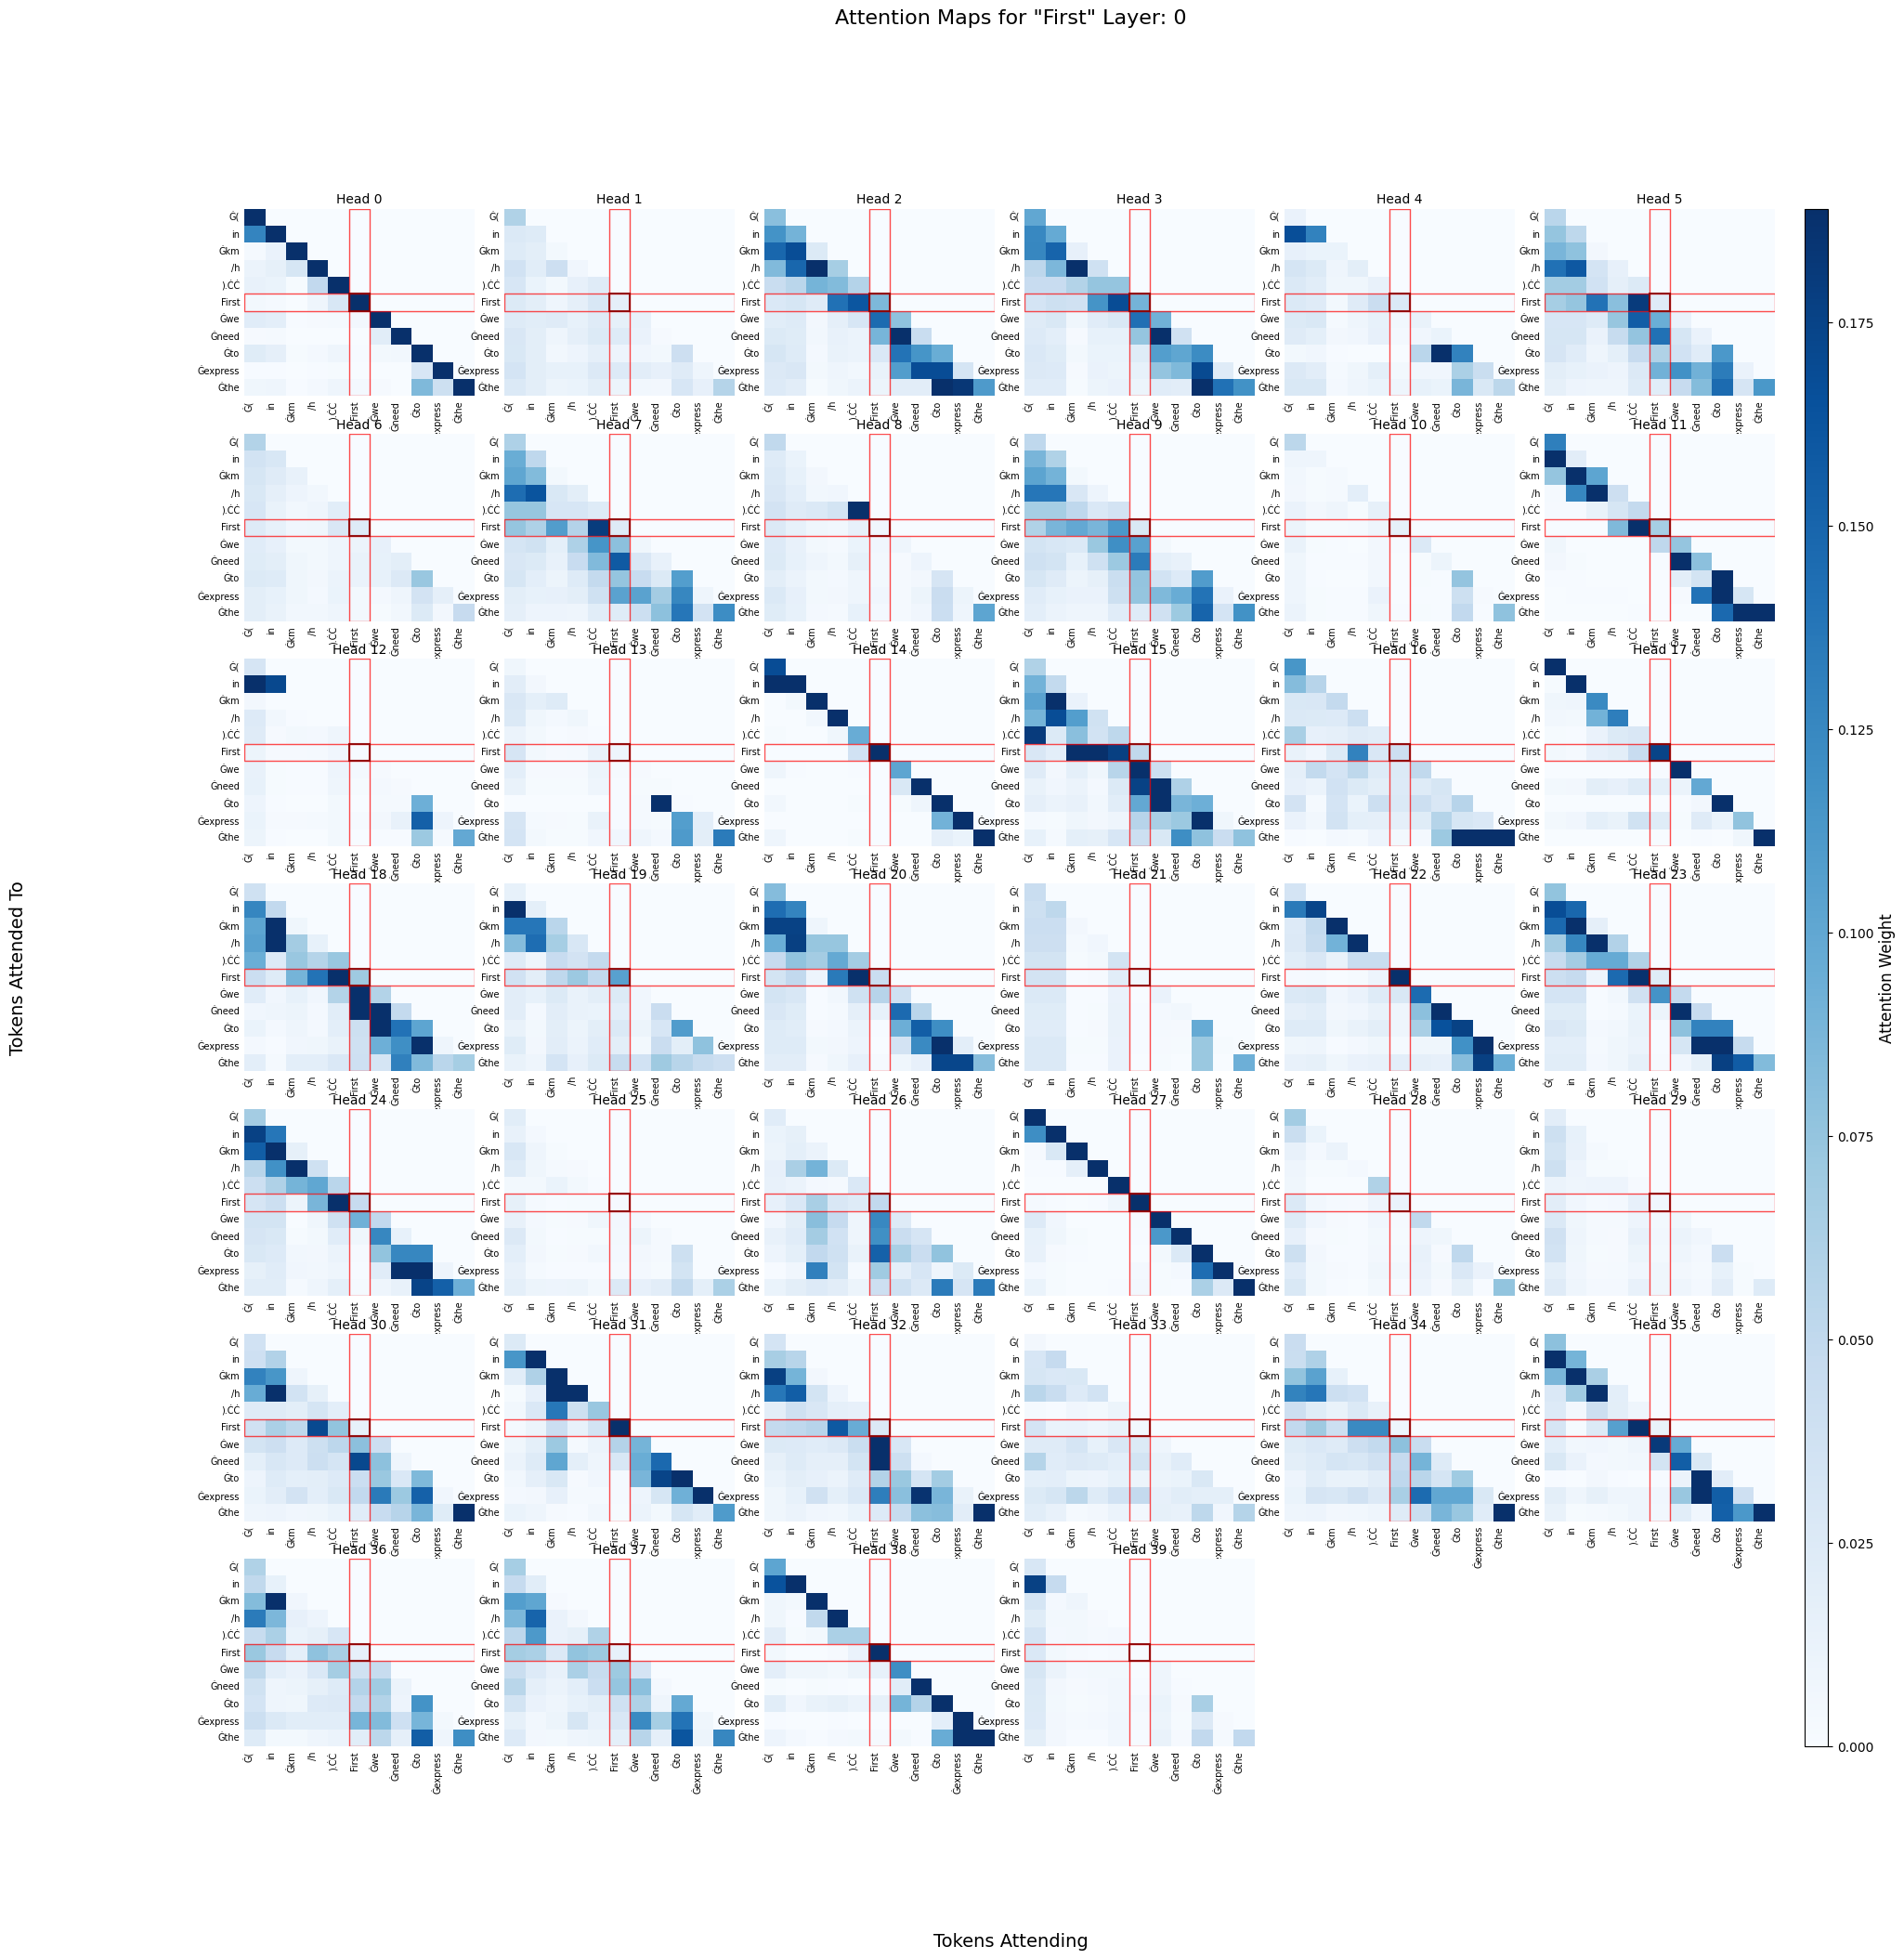

Completed grid visualization for row 0
Focus Index Start: 105, End: 105
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 100, New Focus End: 100
reduced tokens 972 100 100
Input attention shape: (40, 972, 972)
Focus indices: 100, 100
Window indices: start 95, end 106
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.1904 (95th percentile: 0.1270)
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

/tmp/ipykernel_616944/4176357475.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])


Saved to grid_plots/is_step_by_step/layer_0/586fd646-76d6-5070-8c81-9993ab9d8559_is_step_by_step_layer0_grid.png


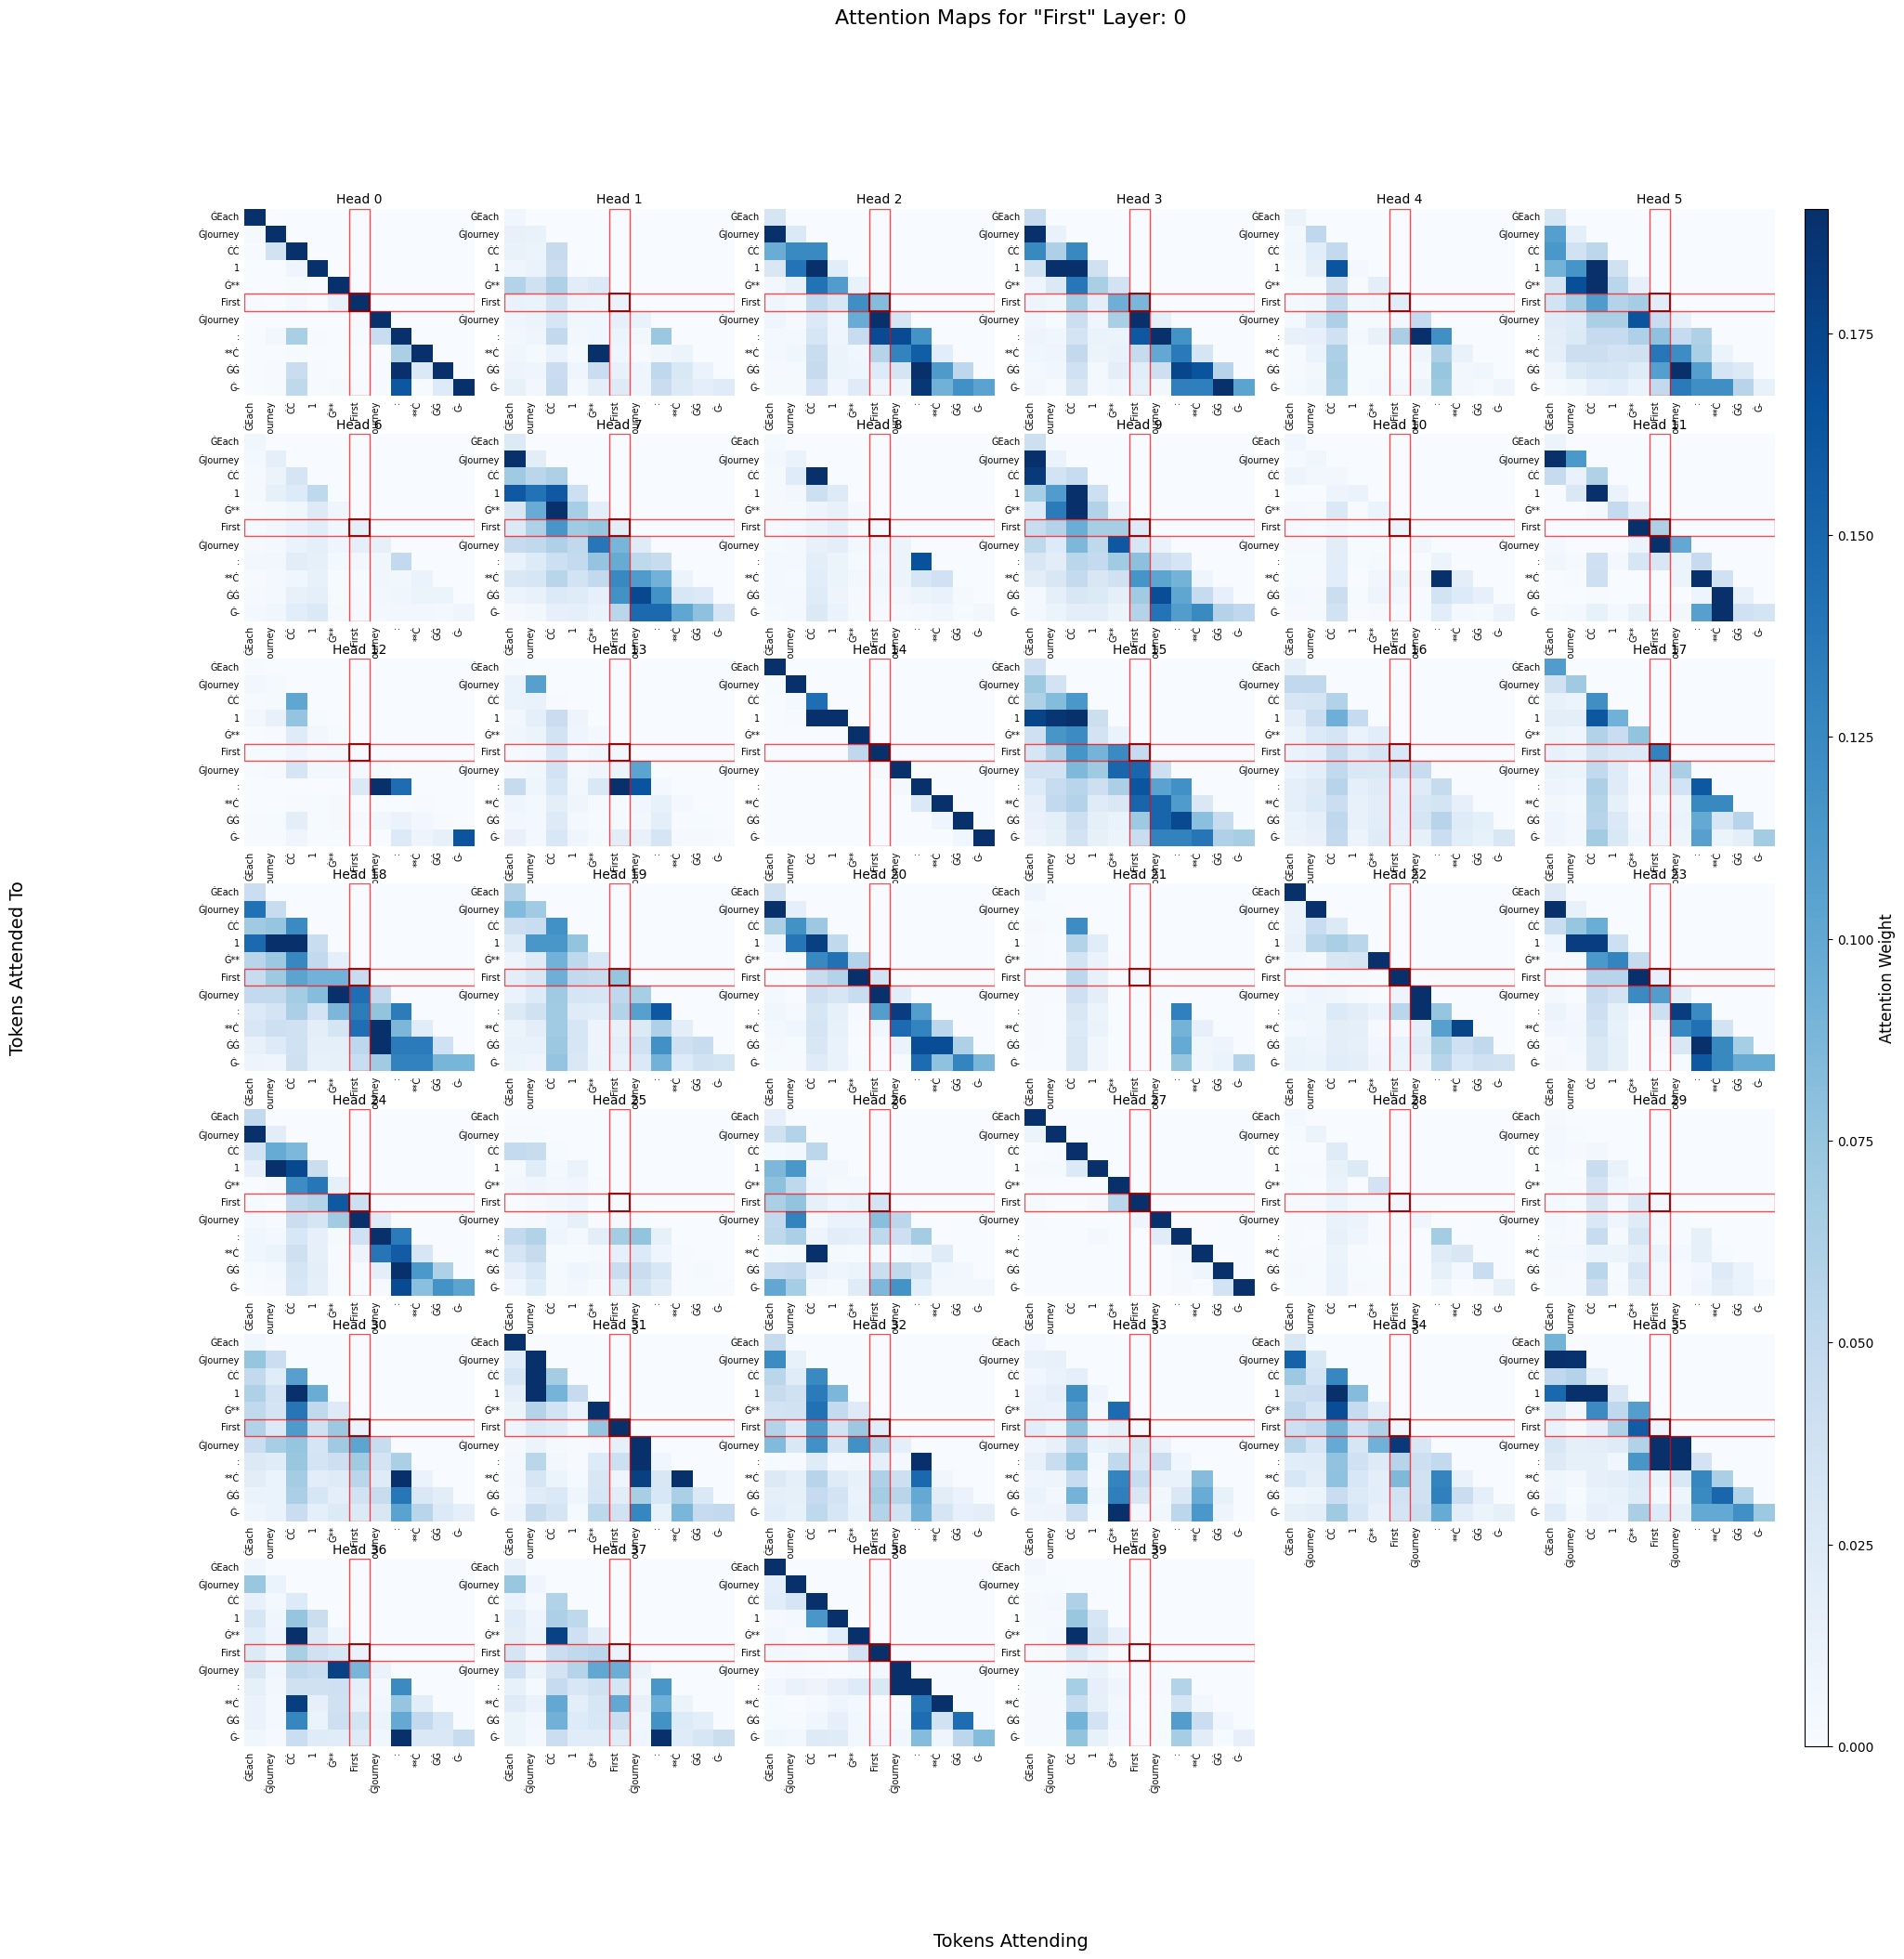

Completed grid visualization for row 0
Extracting attention from layer 16 of 64 layers...
Attention shape for layer 16: torch.Size([40, 1024, 1024])
New attentions shape: torch.Size([40, 1024, 1024])
cue_char_indices [(234, 238), (389, 393)]
Processing UUID: 586fd646-76d6-5070-8c81-9993ab9d8559, Cue: First
Cue Indices: [(63, 63), (105, 105)]
Focus Index Start: 63, End: 63
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 61, New Focus End: 61
reduced tokens 972 61 61
Input attention shape: (40, 972, 972)
Focus indices: 61, 61
Window indices: start 56, end 67
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.0434 (95th percentile: 0.0290)
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

/tmp/ipykernel_616944/4176357475.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])


Saved to grid_plots/is_step_by_step/layer_16/586fd646-76d6-5070-8c81-9993ab9d8559_is_step_by_step_layer16_grid.png


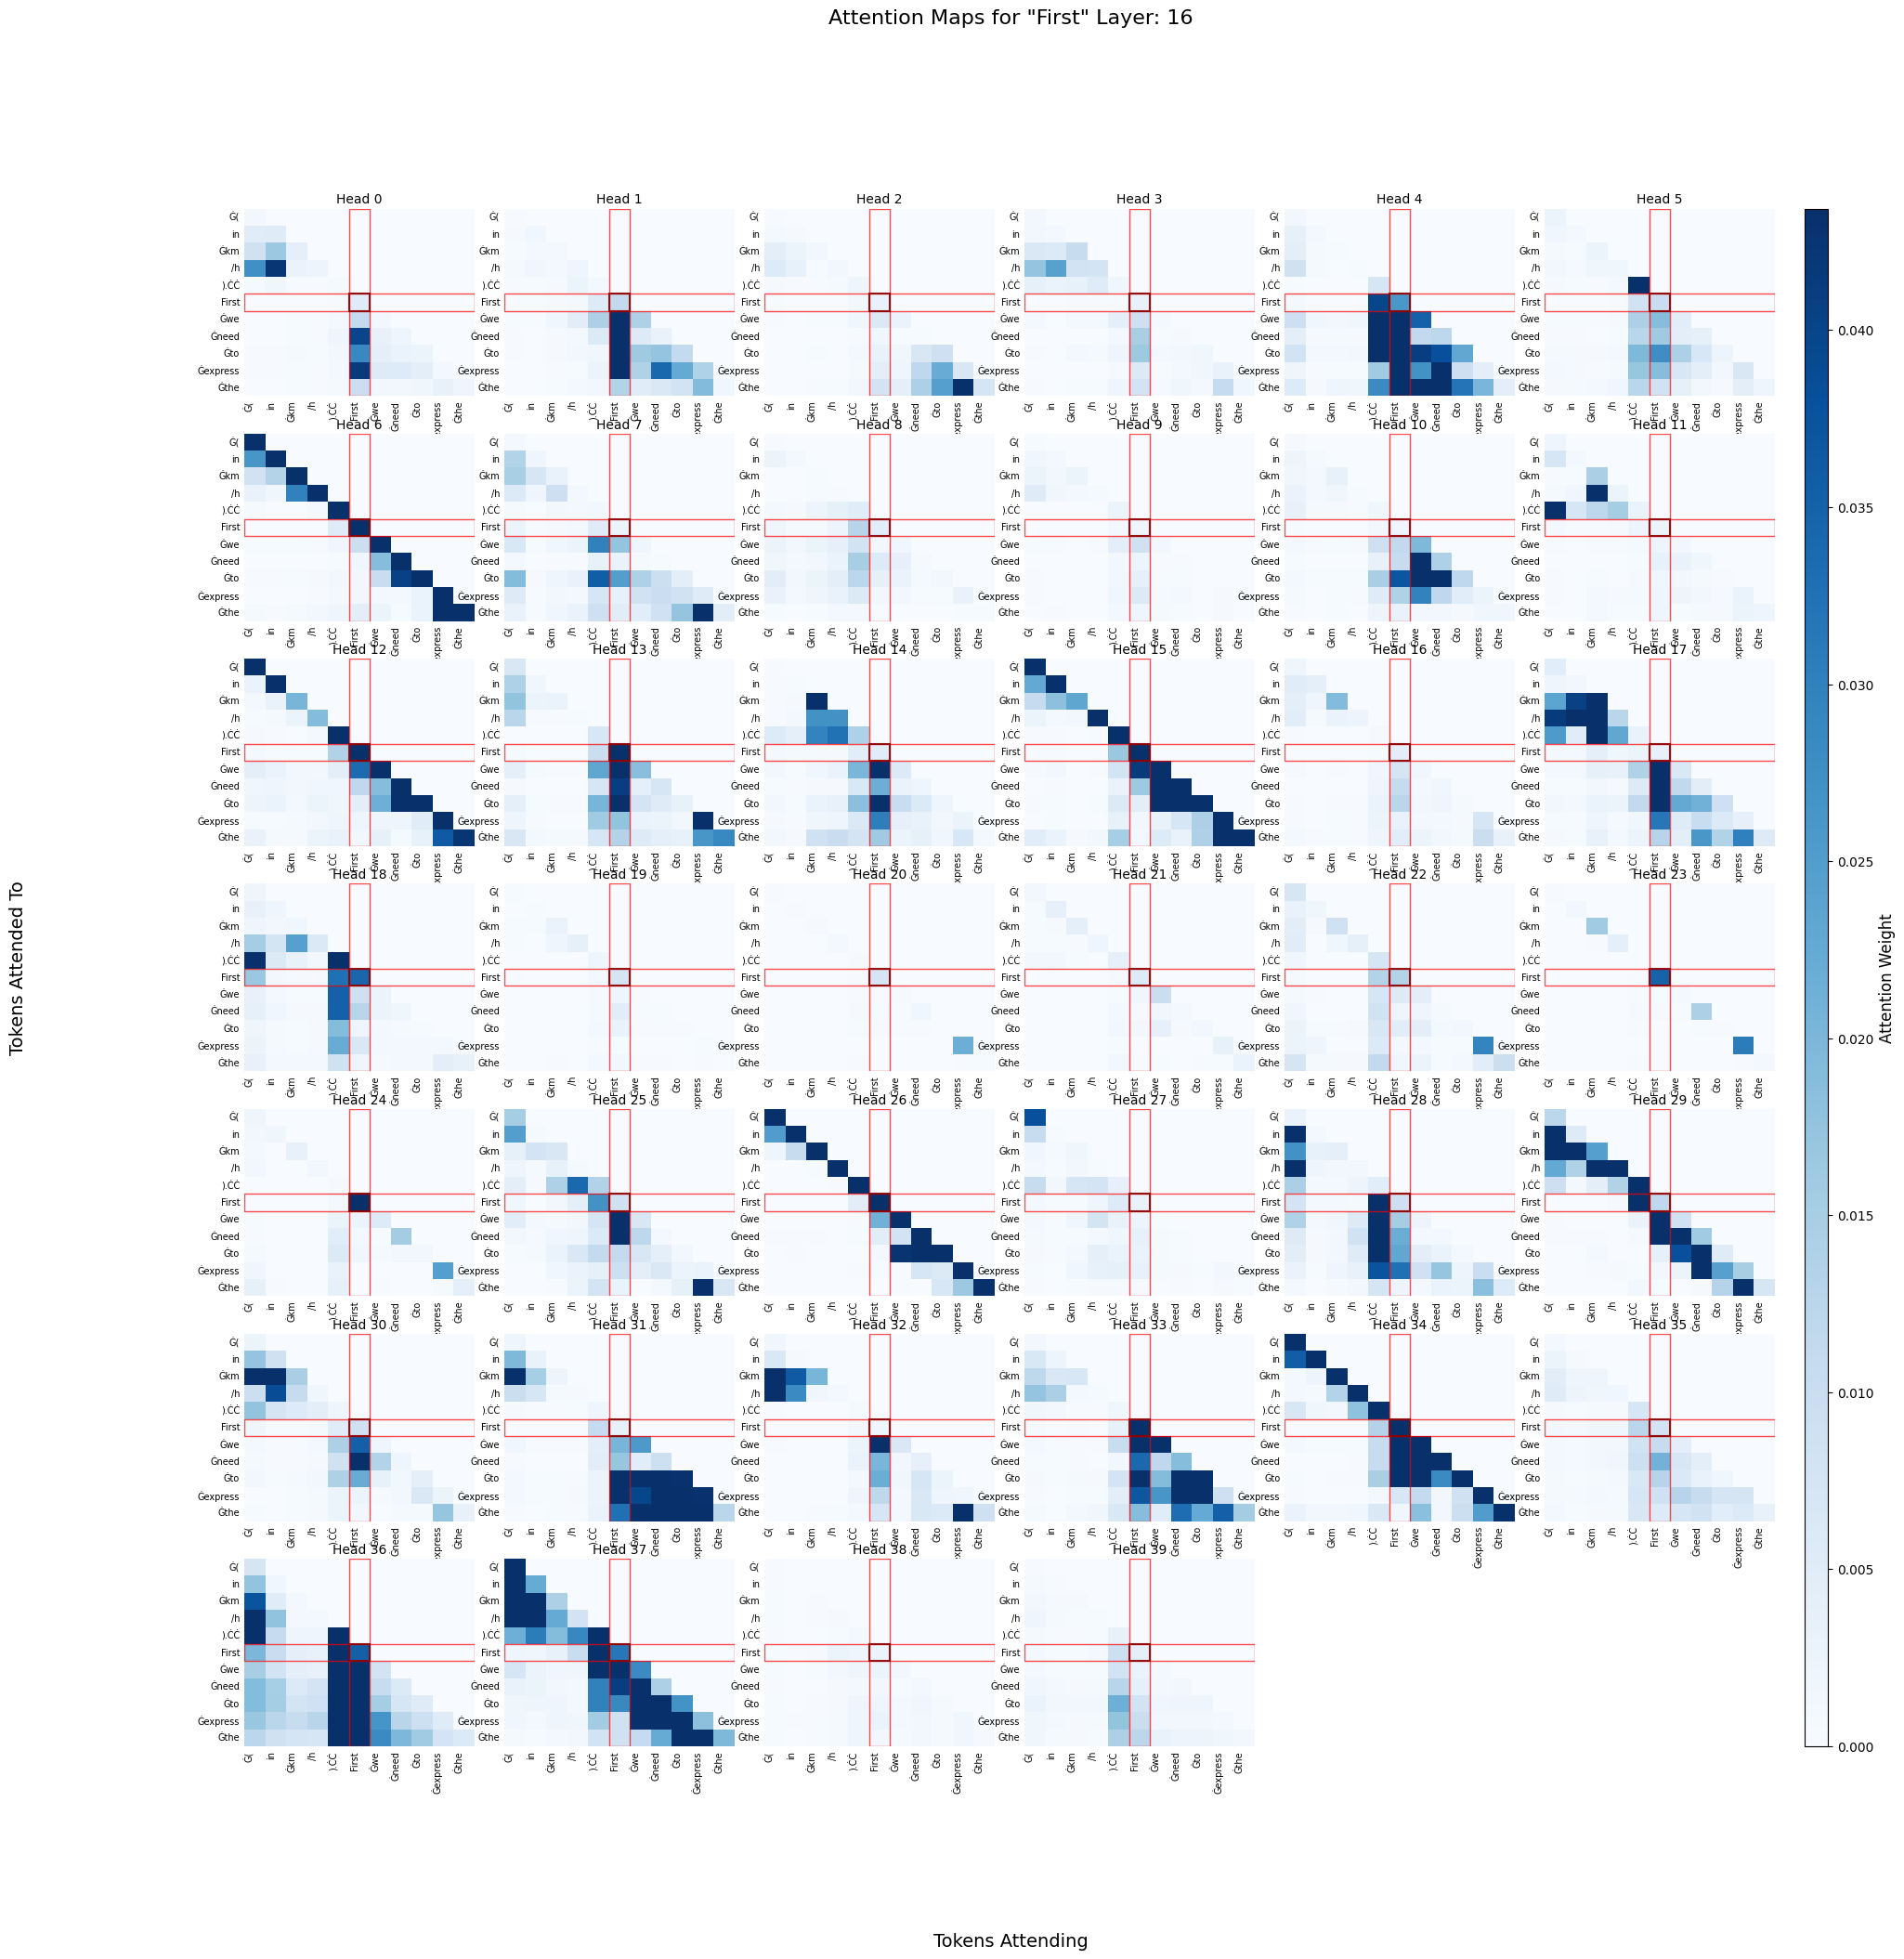

Completed grid visualization for row 0
Focus Index Start: 105, End: 105
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 100, New Focus End: 100
reduced tokens 972 100 100
Input attention shape: (40, 972, 972)
Focus indices: 100, 100
Window indices: start 95, end 106
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.0590 (95th percentile: 0.0393)


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

/tmp/ipykernel_616944/4176357475.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])


Saved to grid_plots/is_step_by_step/layer_16/586fd646-76d6-5070-8c81-9993ab9d8559_is_step_by_step_layer16_grid.png


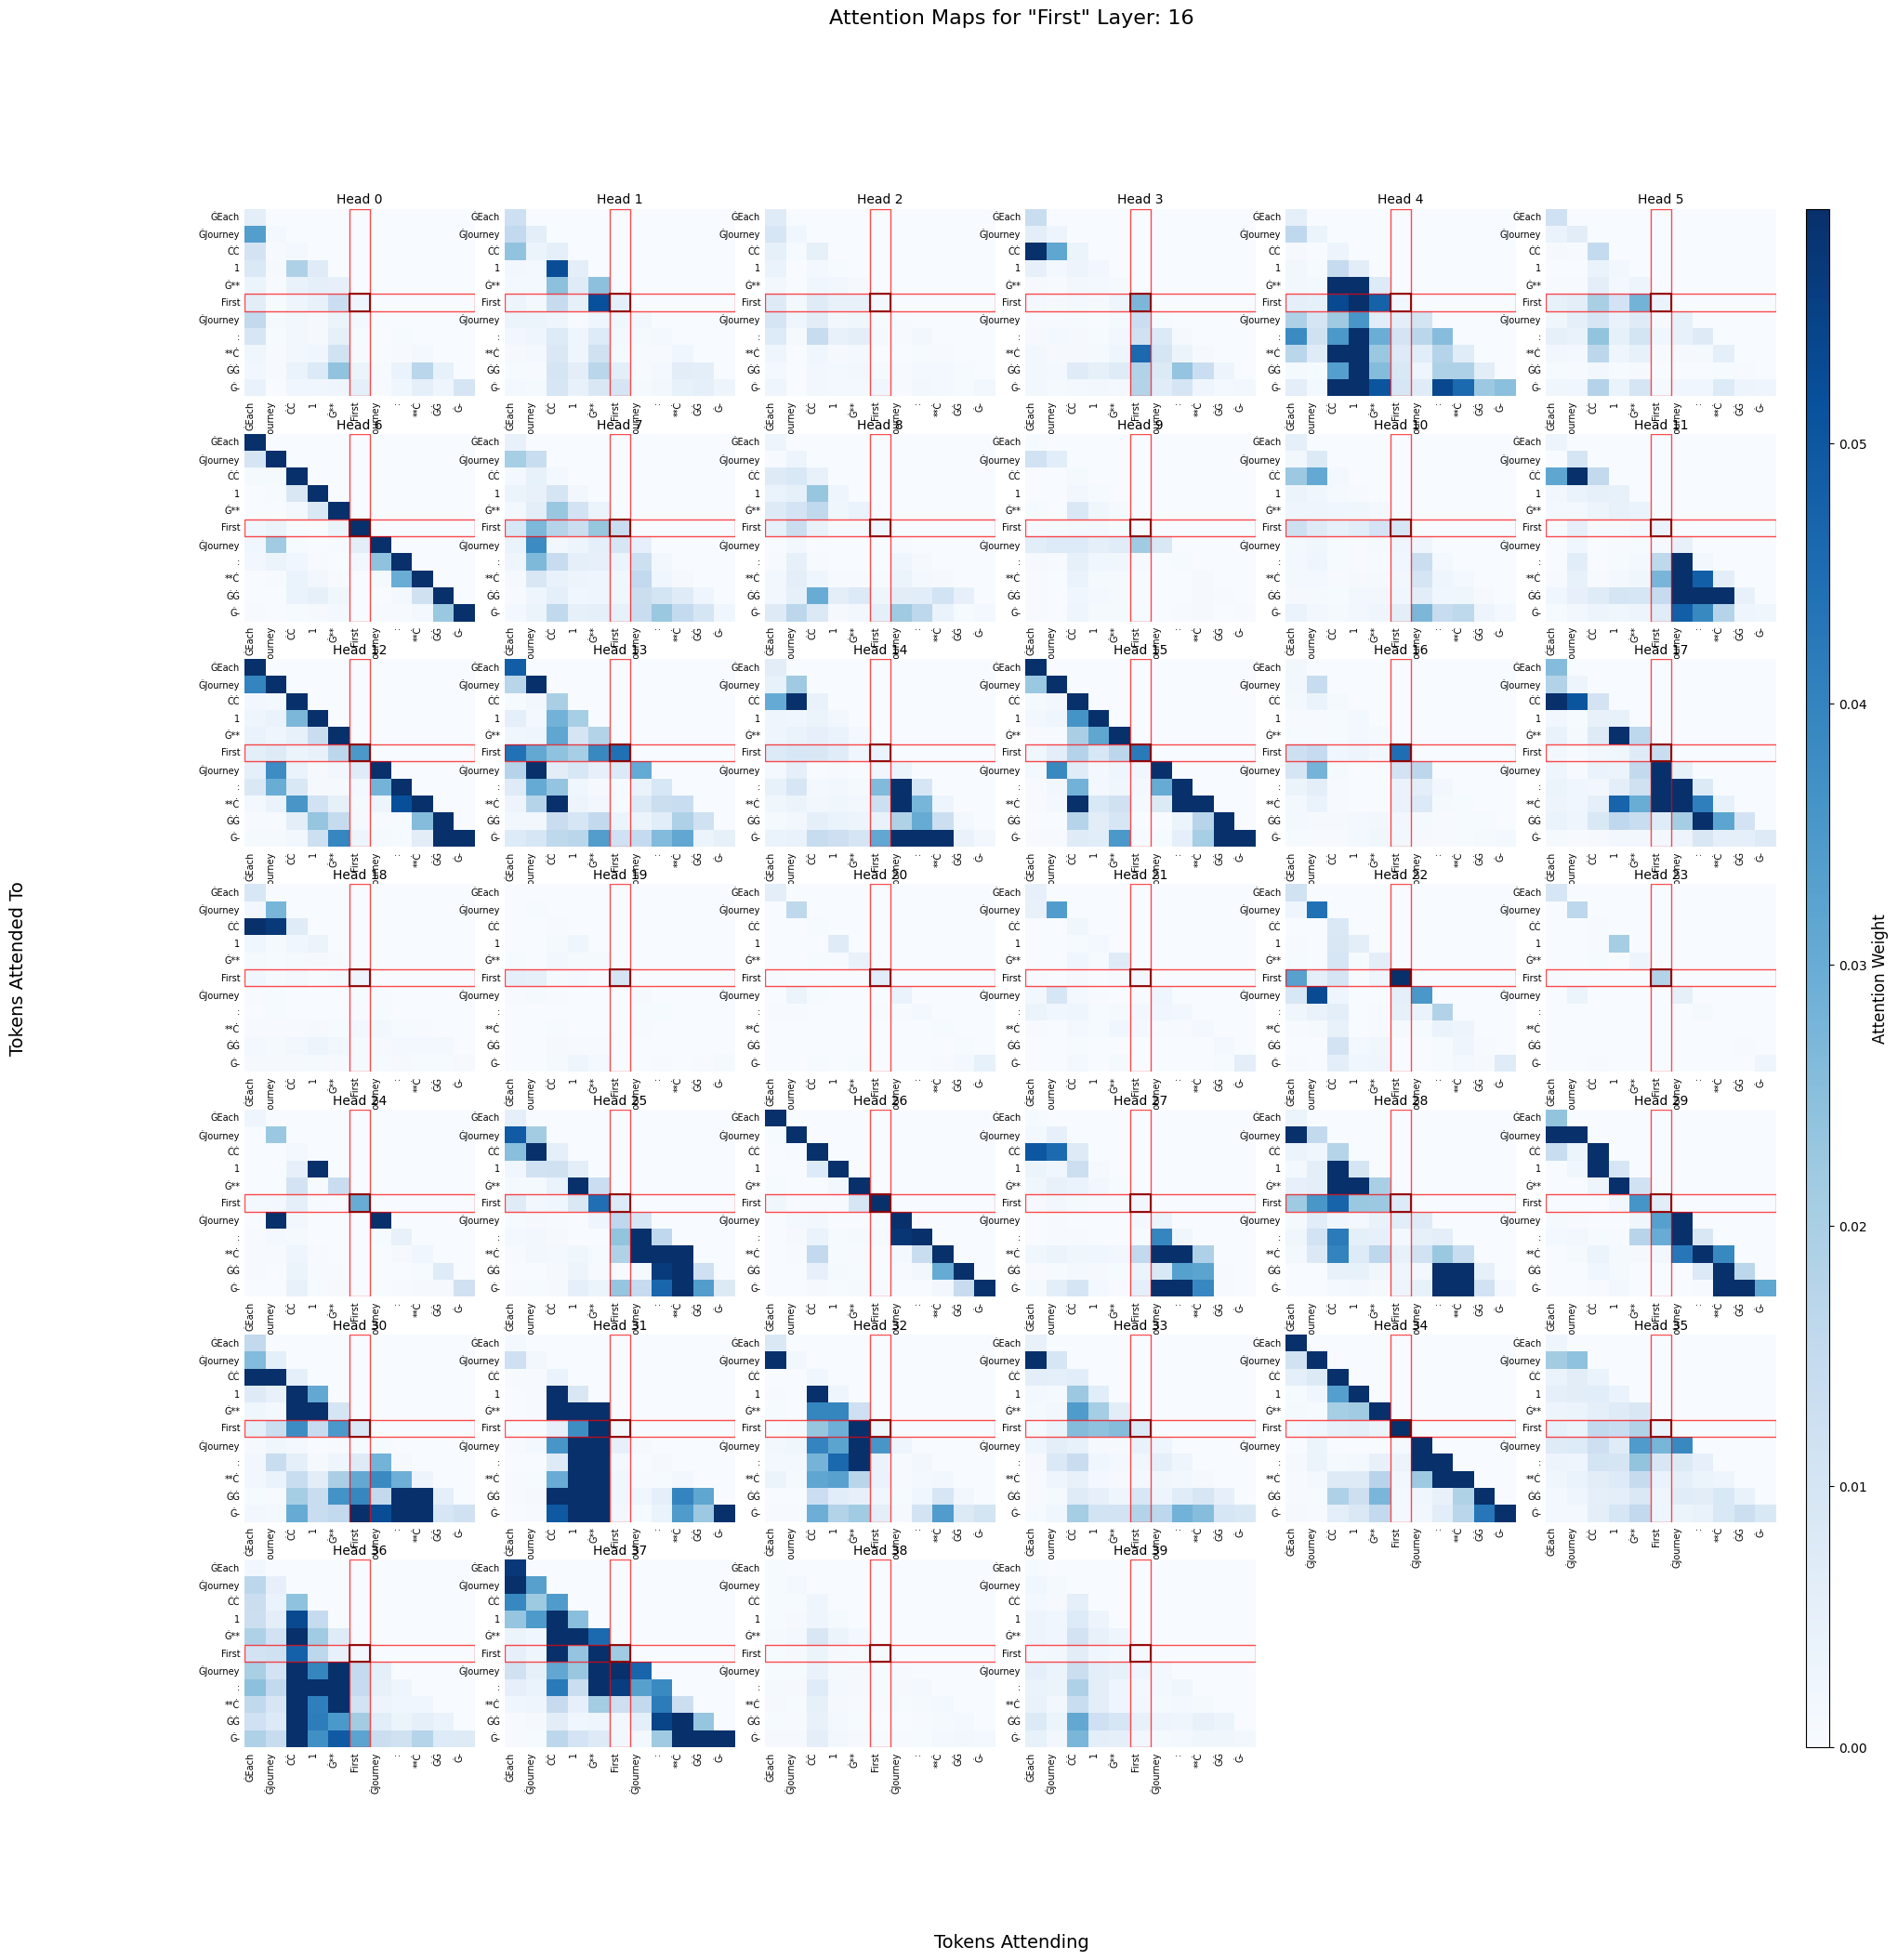

Completed grid visualization for row 0
Extracting attention from layer 32 of 64 layers...
Attention shape for layer 32: torch.Size([40, 1024, 1024])
New attentions shape: torch.Size([40, 1024, 1024])
cue_char_indices [(234, 238), (389, 393)]
Processing UUID: 586fd646-76d6-5070-8c81-9993ab9d8559, Cue: First
Cue Indices: [(63, 63), (105, 105)]
Focus Index Start: 63, End: 63
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 61, New Focus End: 61
reduced tokens 972 61 61
Input attention shape: (40, 972, 972)
Focus indices: 61, 61
Window indices: start 56, end 67
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.0743 (95th percentile: 0.0496)
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

/tmp/ipykernel_616944/4176357475.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])


Saved to grid_plots/is_step_by_step/layer_32/586fd646-76d6-5070-8c81-9993ab9d8559_is_step_by_step_layer32_grid.png


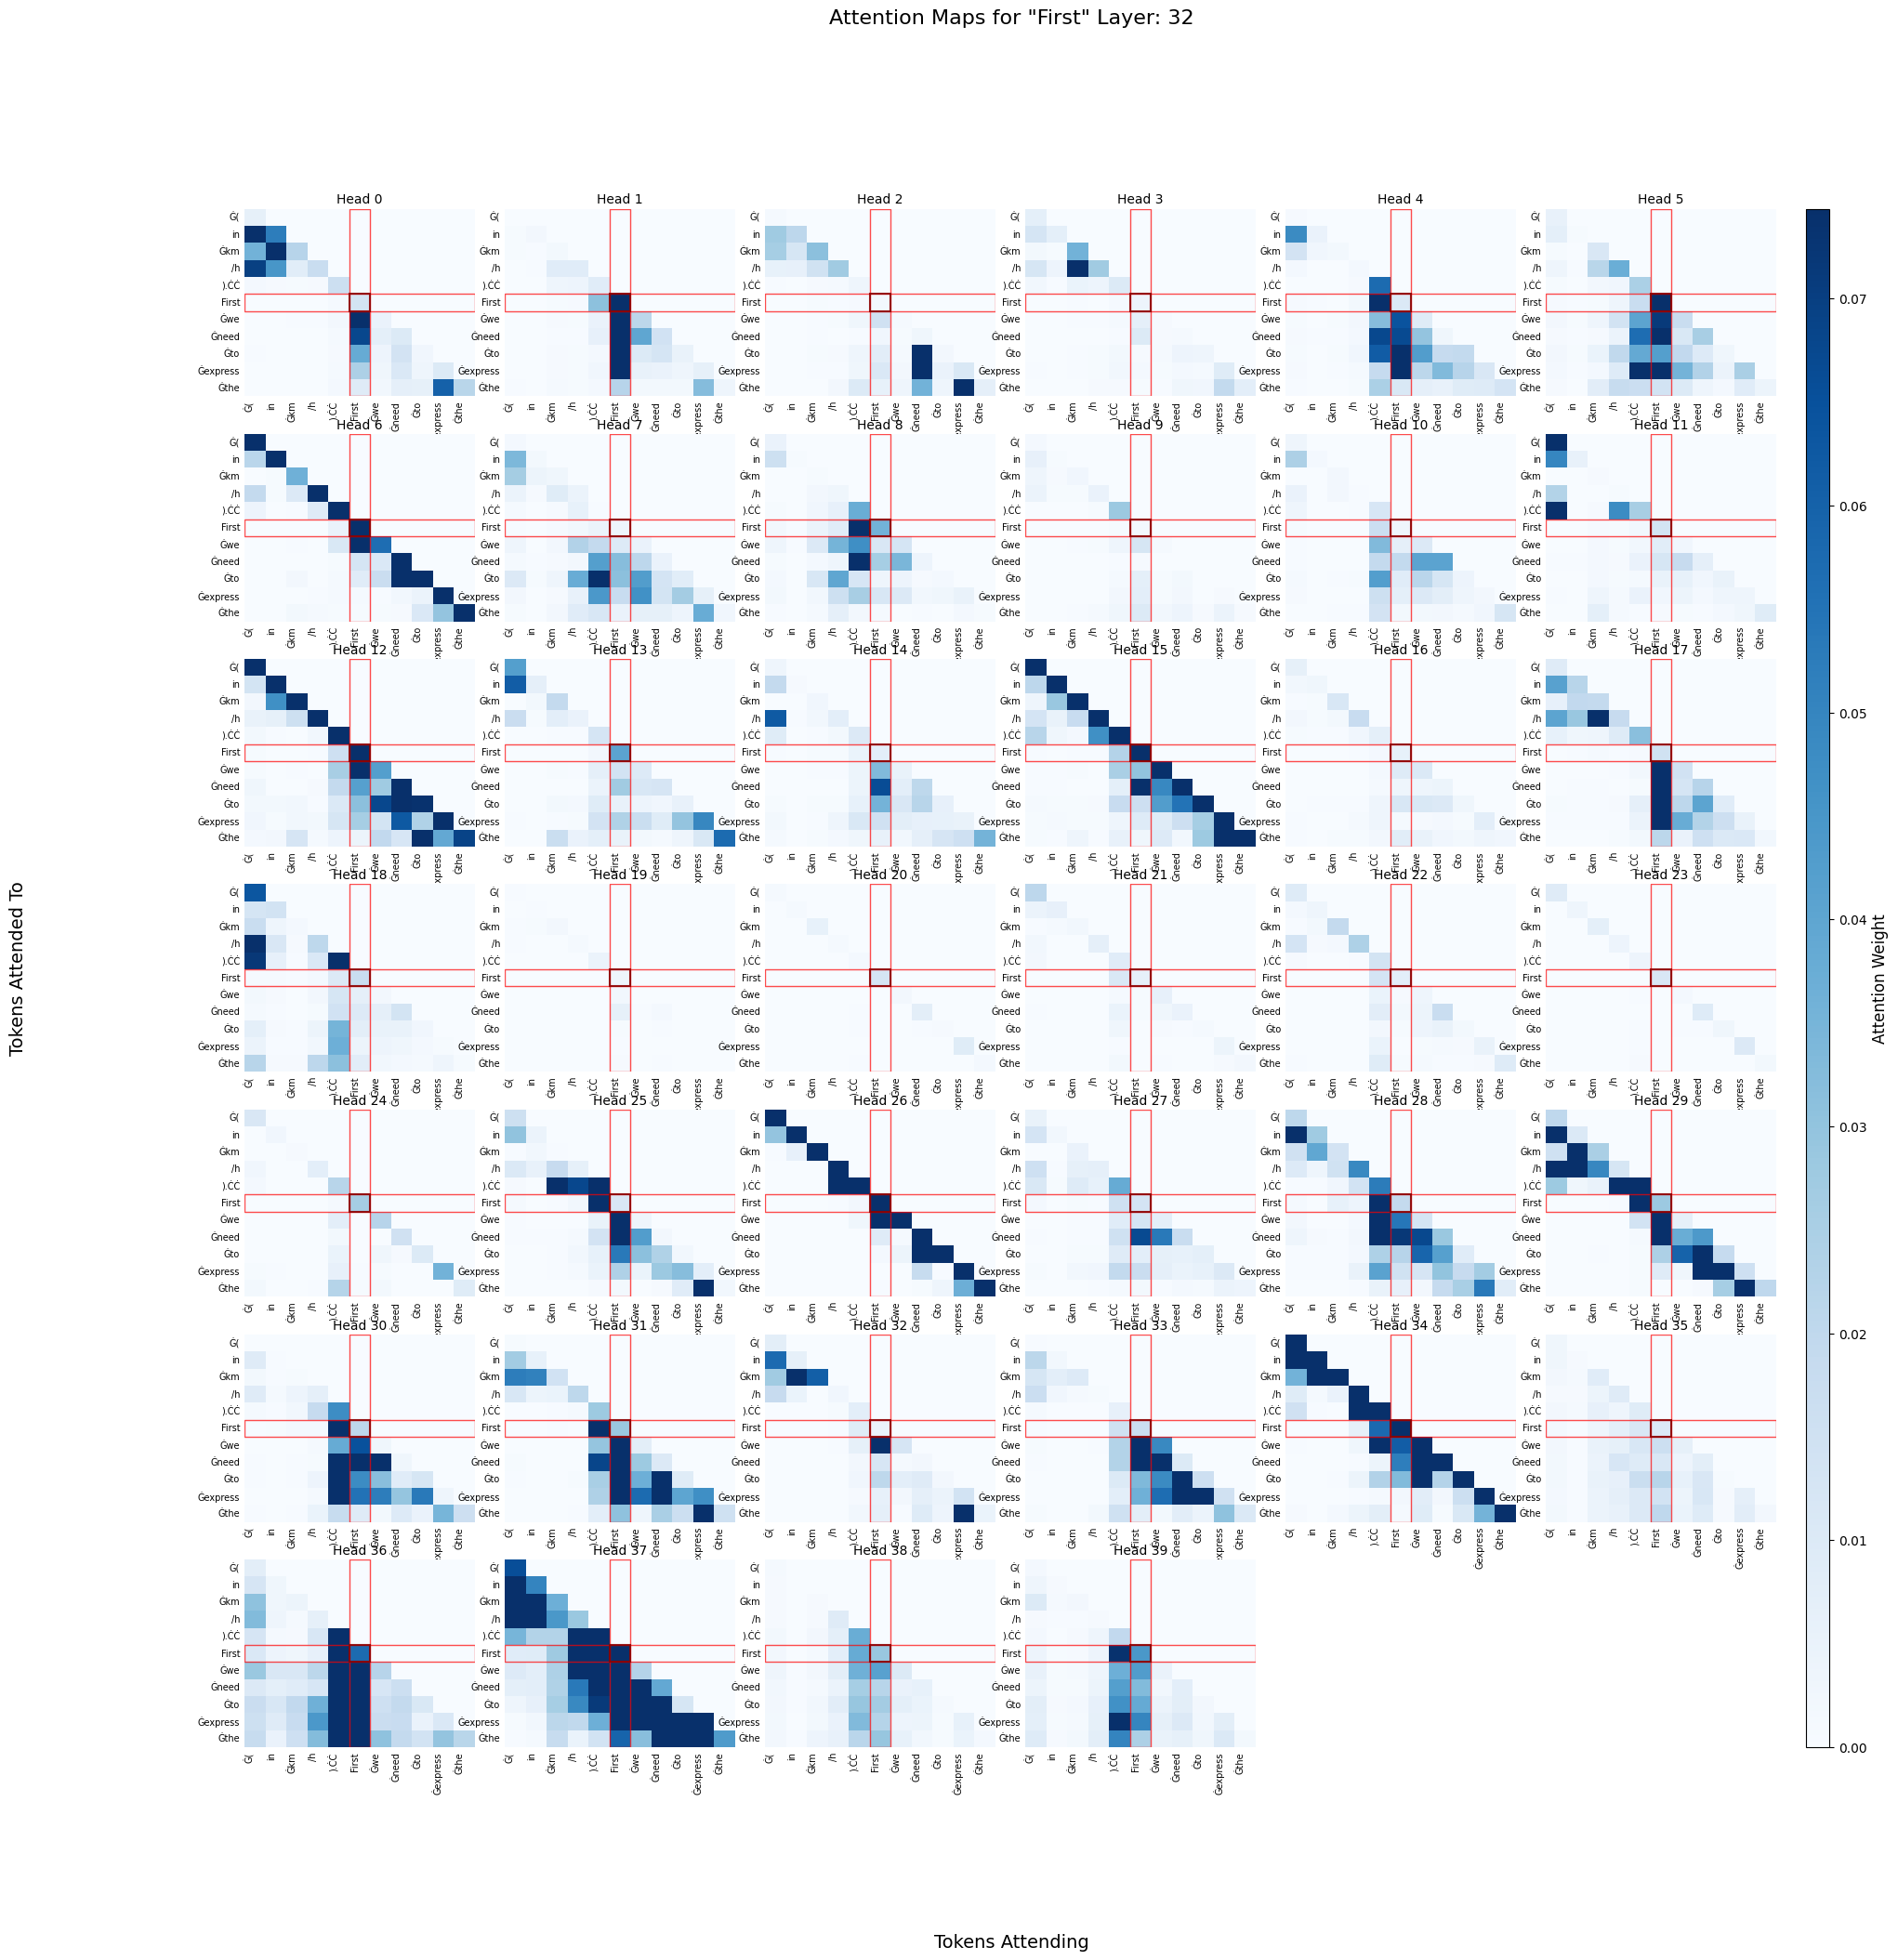

Completed grid visualization for row 0
Focus Index Start: 105, End: 105
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 100, New Focus End: 100
reduced tokens 972 100 100
Input attention shape: (40, 972, 972)
Focus indices: 100, 100
Window indices: start 95, end 106
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.1275 (95th percentile: 0.0850)
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

/tmp/ipykernel_616944/4176357475.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.96])


Saved to grid_plots/is_step_by_step/layer_32/586fd646-76d6-5070-8c81-9993ab9d8559_is_step_by_step_layer32_grid.png


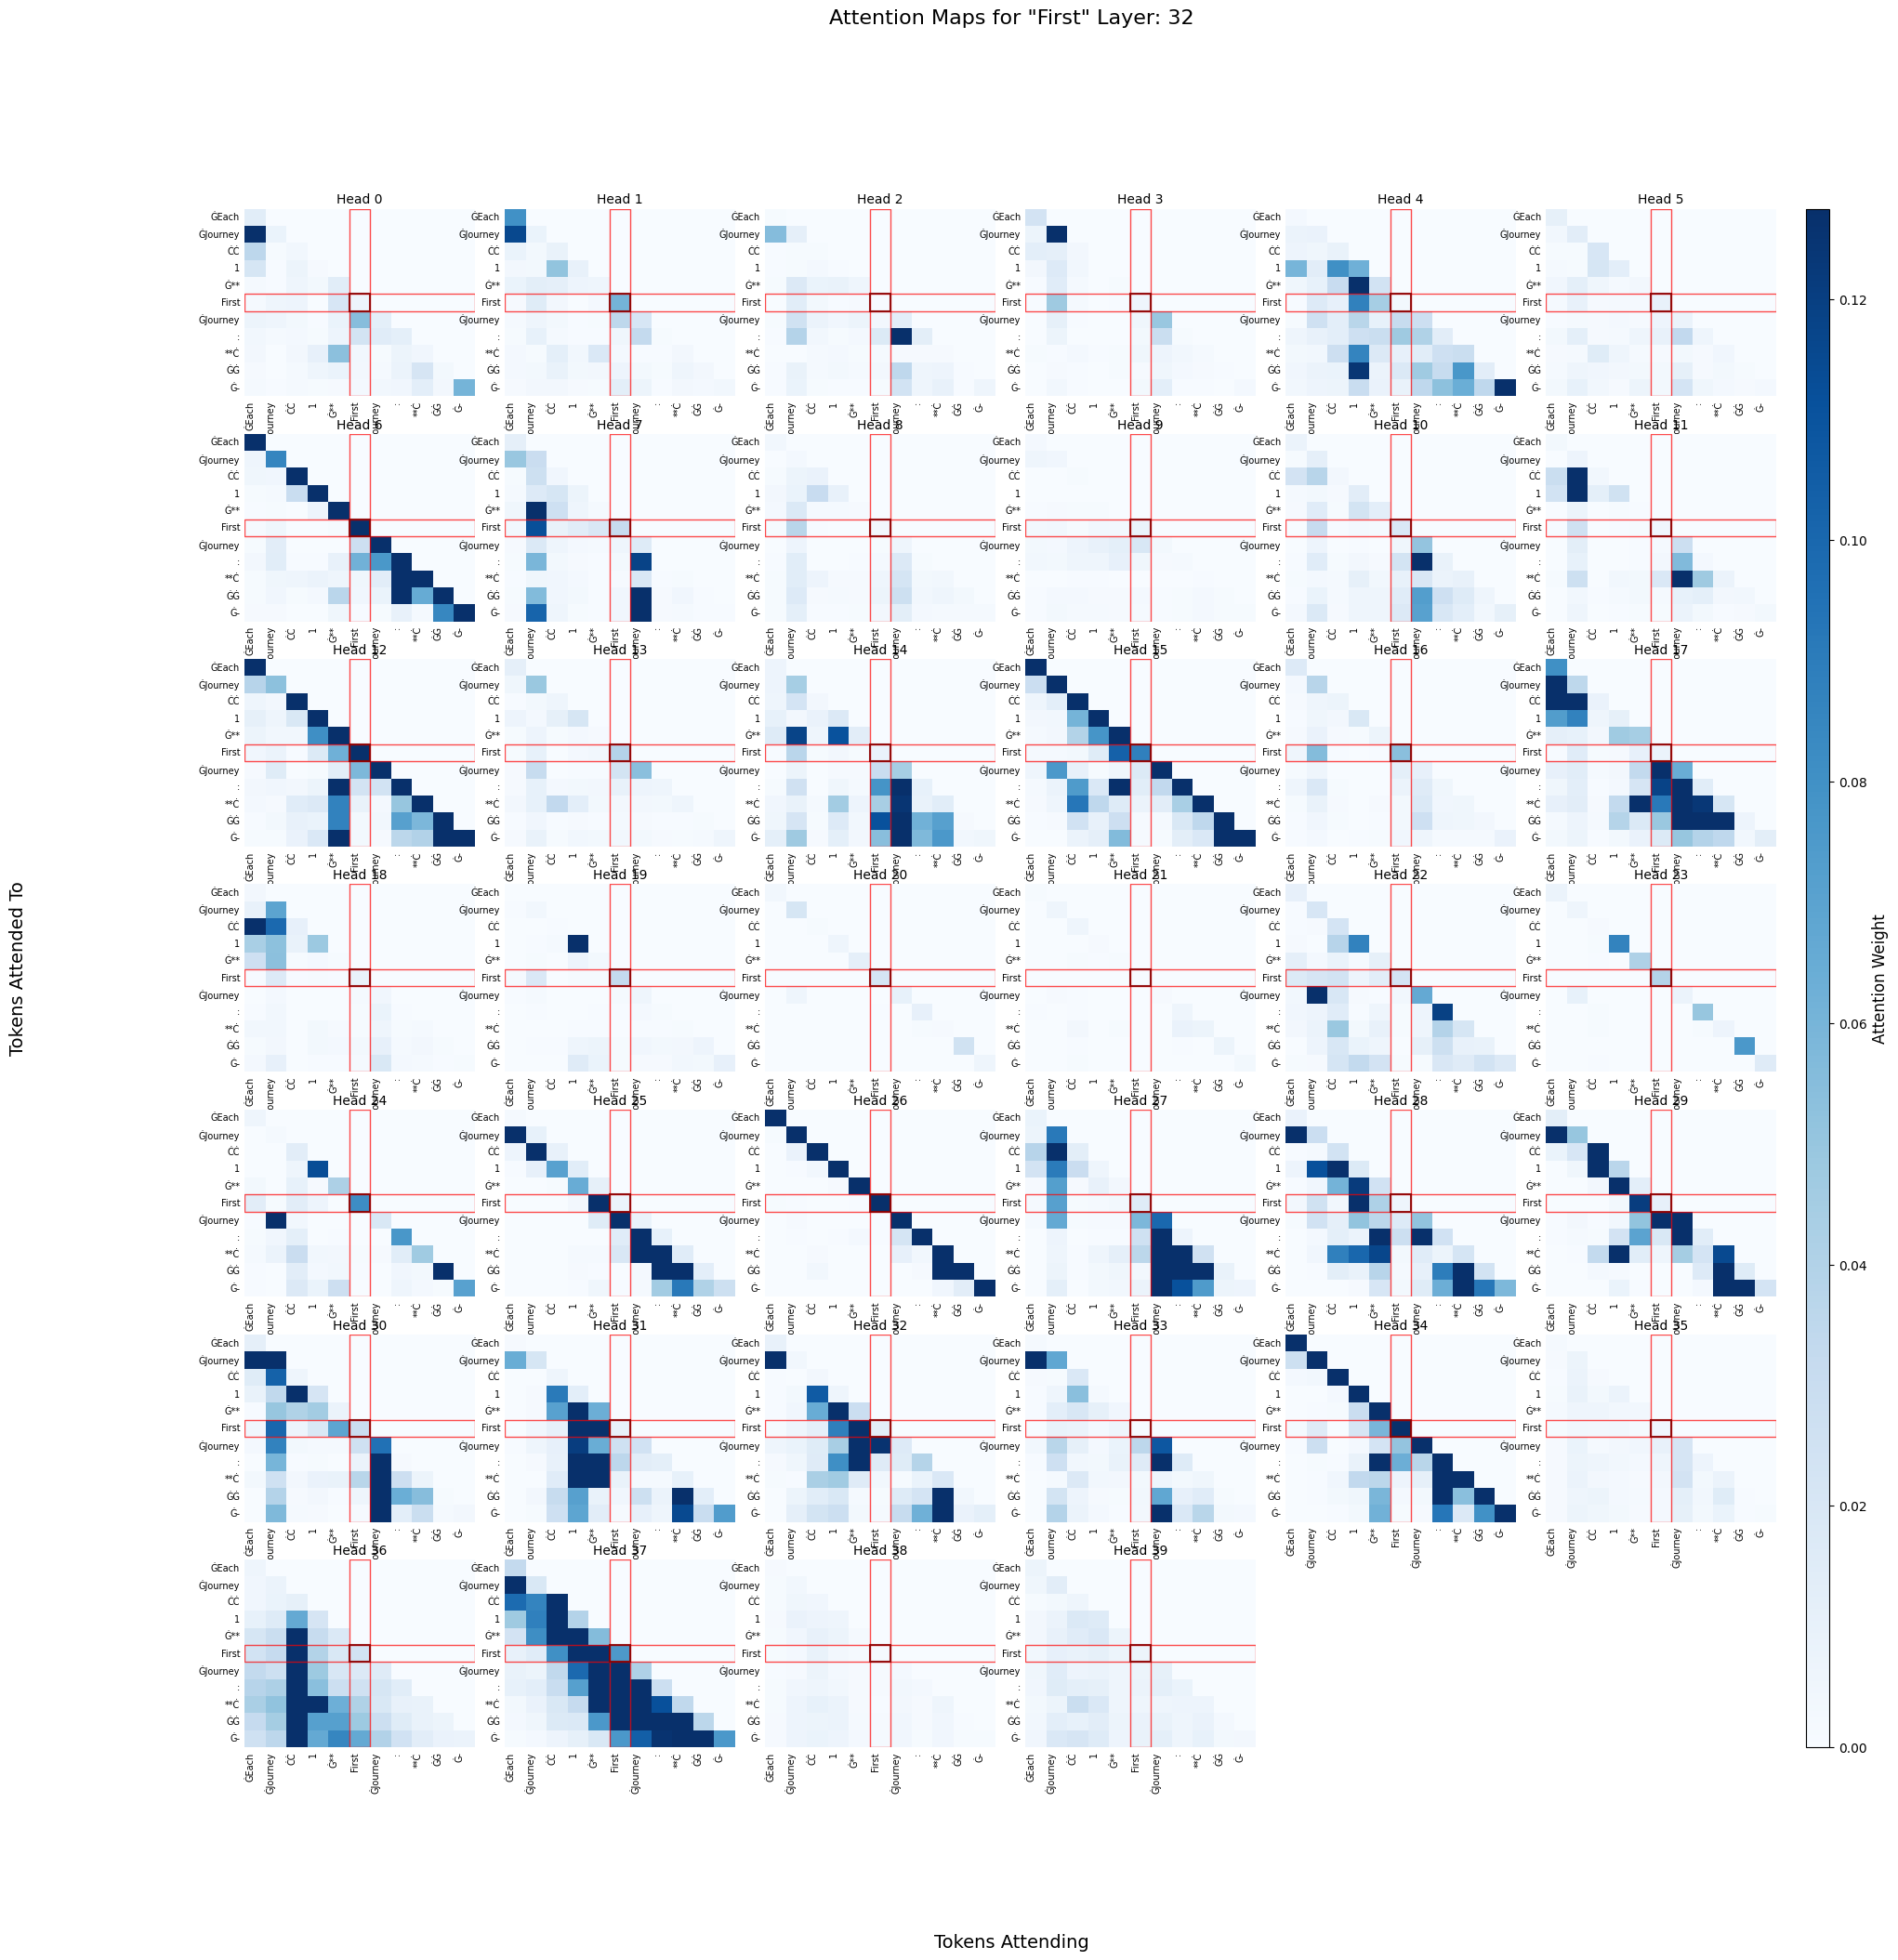

Completed grid visualization for row 0
Extracting attention from layer 48 of 64 layers...
Attention shape for layer 48: torch.Size([40, 1024, 1024])
New attentions shape: torch.Size([40, 1024, 1024])
cue_char_indices [(234, 238), (389, 393)]
Processing UUID: 586fd646-76d6-5070-8c81-9993ab9d8559, Cue: First
Cue Indices: [(63, 63), (105, 105)]
Focus Index Start: 63, End: 63
attn_matrix 40
original token in cue First
new token in cue First
here
Reduced attention shape: (40, 972, 972)
New Focus Index Start: 61, New Focus End: 61
reduced tokens 972 61 61
Input attention shape: (40, 972, 972)
Focus indices: 61, 61
Window indices: start 56, end 67
Relative focus position: 5, 5
Window size: 11 tokens
Adjusting colormap max to 0.0740 (95th percentile: 0.0493)
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1


/tmp/ipykernel_616944/4176357475.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Base colormap


Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions: 5, 5
Rectangle: x=5, y=5, w=1, h=1
Original focus positions

In [ ]:
import os
import matplotlib.gridspec as gridspec

# Iterate through each sampled example
for idx, row in sampled_df.iterrows():
    # row = df.iloc[0]  # Get the first row
    
    # Access values from the first row
    reasoning_key = row["cot_reasoning_key"]
    reasoning_value = row["cot_reasoning_value"]
    uuid = row["uuid"]
    input_text = row["model_response"]
    
    # print(reasoning_key, reasoning_value, uuid, input_text)
    
    
    # Tokenize and get model outputs
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True, return_dict=True)

    # Define which layers to extract attention from
    num_layers = len(outputs.attentions)
    layer_indices = [0, num_layers // 4, num_layers // 2, 3 * num_layers // 4, -1]  # First, 25%, 50%, 75%, Last layer

     # Iterate over the selected layers
    for layer_idx in layer_indices:
        print(f"Extracting attention from layer {layer_idx} of {num_layers} layers...")
    
        # Extract attention maps for the given layer
        attentions = outputs.attentions[layer_idx]  # Shape: [batch_size, num_heads, seq_len, seq_len]
        attentions = attentions.squeeze(0)  # Remove batch dimension → Shape: [num_heads, seq_len, seq_len]
    
        print(f"Attention shape for layer {layer_idx}: {attentions.shape}")

        # # Extract attention maps from the last layer
        # attentions = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
        
        # # Remove batch dimension (assuming batch_size=1)
        # attentions = attentions.squeeze(0)  # Now shape: [num_heads, seq_len, seq_len]
        
        print(f"New attentions shape: {attentions.shape}")  # Should be (num_heads, seq_len, seq_len)
    
        # Define cue
        cue = reasoning_value if pd.notna(reasoning_value) else None
        tokens, cue_indices = find_cue_indices(tokenizer, input_text, cue)
        
        
        print(f"Processing UUID: {uuid}, Cue: {cue}")
        print("Cue Indices:", cue_indices)
        
        for focus_idx_start, focus_idx_end in cue_indices:
            print(f"Focus Index Start: {focus_idx_start}, End: {focus_idx_end}")
        
            # Remove unwanted tokens & update the focus index
            reduced_attn_matrix, reduced_tokens, new_focus_idx_start, new_focus_idx_end = remove_unwanted_tokens(
                tokens, attentions, focus_idx_start, focus_idx_end
            )
            print(f"New Focus Index Start: {new_focus_idx_start}, New Focus End: {new_focus_idx_end}")
            print("reduced tokens", len(reduced_tokens), new_focus_idx_start, new_focus_idx_end)
        
            # Clean tokens for visualization
            cleaned_tokens = clean_tokens(reduced_tokens)
            # Create save directory
            # Create save directory
            save_dir = "grid_plots"
            layer_save_dir = os.path.join(save_dir, reasoning_key, f"layer_{layer_idx}")
            os.makedirs(layer_save_dir, exist_ok=True)

            example_save_dir = os.path.join(save_dir, reasoning_key)
            os.makedirs(example_save_dir, exist_ok=True)
            
            # Define save path for this layer
            save_path = os.path.join(layer_save_dir, f"{uuid}_{reasoning_key}_layer{layer_idx}_grid.png")
            # save_path = os.path.join(example_save_dir, f"{uuid}_{reasoning_key}_last_layer_grid.png")
            title = f'Attention Maps for "{cue}" Layer: {layer_idx}'
            # Plot the grid of attention heads
            plot_attention_grid_pretty(
                reduced_attn_matrix,
                reduced_tokens,
                new_focus_idx_start,
                new_focus_idx_end,
                window_size=5,
                reasoning_cue=cue,
                save_path=save_path,
                grid_rows=7,
                grid_cols=6, 
                title = title
            )
            
            print(f"Completed grid visualization for row {idx}")
    


In [ ]:
# looking at other reasoning operations
# looking at approaches to detemrining faithful chain of thought
# looking at the heuristics why it decides to backtrack

In [271]:
# Define a backtracking example
input_text = df["model_response"][14]

# Tokenize and get model outputs
inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True, return_dict=True)

# Extract attention maps from last layer
attentions = outputs.attentions[-1]  # Last layer attention

# Convert to numpy
attentions = attentions.cpu().to(torch.float32).numpy()




KeyboardInterrupt: 

1023 [(15, 15)]
cue indicies [(15, 15)]
15 15
867 867
867 867


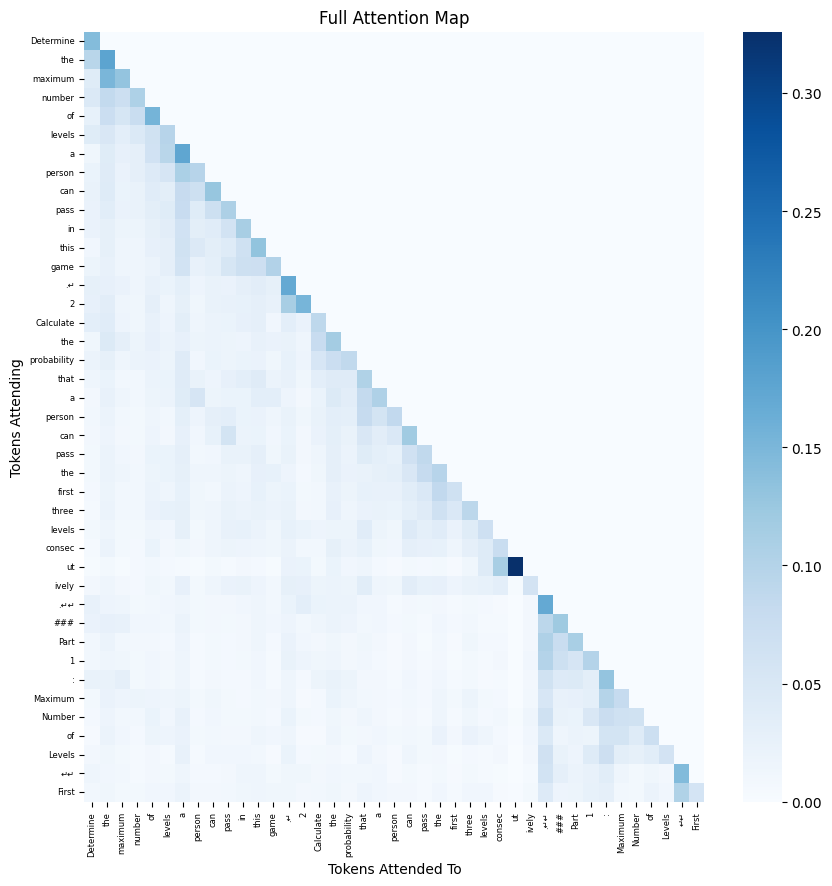

In [275]:
cue = None
# cue_indices is a list of tuples
tokens, cue_indices = find_cue_indices(tokenizer, input_text, cue)
print("cue indicies", cue_indices)
if cue_indices:
    for focus_idx_start, focus_idx_end in cue_indices:
        print(focus_idx_start, focus_idx_end)
        # plot_attention_map_windowed(attentions[0], tokens, focus_idx_start, focus_idx_end, window_size=3)
        # Remove unwanted tokens & update the focus index
        attn_matrix = attentions[-1] #last layer
        attn_matrix = attn_matrix.mean(axis=0)  # Average over all heads (Shape: seq_len x seq_len)

        reduced_attentions, reduced_tokens, new_focus_idx_start, new_focus_idx_end = remove_unwanted_tokens(tokens, attn_matrix, focus_idx_start, focus_idx_end)
        print(len(reduced_attn_matrix), len(reduced_attn_matrix[0]))
        # reduced_tokens = clean_tokens(reduced_tokens)
        cleaned_tokens = clean_tokens(reduced_tokens)
        if new_focus_idx is not None:  # Ensure the focus index is still valid
            plot_attention_map_windowed(reduced_attentions, cleaned_tokens, new_focus_idx_start, new_focus_idx_end, window_size=40, reasoning_cue=cue, save_path="attention_maps/example_none.png")

else:
    print("No valid indices found.")


In [266]:
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/dipika/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [233]:
import re

def clean_tokens(tokens):
    """
    Cleans tokenizer output to make it more readable by:
    1. Removing the 'Ġ' prefix (byte-level BPE tokenizer space marker)
    2. Replacing 'Ċ' with newline indicators
    3. Joining subword tokens where appropriate
    Parameters:
    tokens -- List of tokens from the tokenizer
    Returns:
    list -- Cleaned tokens for better readability in visualizations
    """
    cleaned_tokens = []
    current_token = ""
    
    for token in tokens:
        # Replace the special characters
        cleaned = token.replace('Ġ', ' ')  # Space marker
        cleaned = cleaned.replace('Ċ', '↵')  # Newline marker with a visible symbol
        # If token doesn't start with a space and isn't punctuation, it's likely a subword
        if not token.startswith('Ġ') and not token in [',', '.', ':', ';', '?', '!', ')', '(', '-', '"', "'"]:
            # Subword - append to previous token
            current_token += cleaned
        else:
            # New word or punctuation
            if current_token:
                cleaned_tokens.append(current_token)
            current_token = cleaned
    
    # Add the last token if there's anything left
    if current_token:
        cleaned_tokens.append(current_token)
    
    return cleaned_tokens

cleaned_tokens = clean_tokens(reduced_tokens)
print(cleaned_tokens)


['To', ' solve', ' this', ' problem', ' we', ' need', ' to', ' address', ' two', ' main', ' questions:↵↵1', ' Determine', ' the', ' maximum', ' number', ' of', ' levels', ' a', ' person', ' can', ' pass', ' in', ' this', ' game.↵2', ' Calculate', ' the', ' probability', ' that', ' a', ' person', ' can', ' pass', ' the', ' first', ' three', ' levels', ' consecutively.↵↵###', ' Part1', ':', ' Maximum', ' Number', ' of', ' Levels↵↵First', ' we', ' need', ' to', ' understand', ' the', ' rules', ' of', ' the', ' game', ' On', ' the', ' \\(n\\)-th', ' level', ' a', ' die', ' is', ' rolled', ' \\(n\\)', ' times', ' and', ' the', ' sum', ' of', ' the', ' points', ' must', ' be', ' greater', ' than', ' \\(2^n\\)', ' to', ' pass', ' the', ' level.↵↵A', ' standard', ' die', ' has', ' faces', ' numbered', ' from1', ' to6', ' Therefore', ' the', ' minimum', ' sum', ' for', ' \\(n\\)', ' rolls', ' is', ' \\(n', ' \\times1', ' =', ' n\\),', ' and', ' the', ' maximum', ' sum', ' is', ' \\(n', ' \\time

In [234]:
len(reduced_tokens), len(cleaned_tokens)

(867, 472)

In [219]:
cleaned_tokens = clean_tokens(reduced_tokens)

In [220]:
len(reduced_tokens), len(cleaned_tokens)

(867, 867)

In [221]:
cleaned_tokens

['To',
 'solve',
 'this',
 'problem',
 'we',
 'need',
 'to',
 'address',
 'two',
 'main',
 'questions',
 ':↵↵',
 '1',
 'Determine',
 'the',
 'maximum',
 'number',
 'of',
 'levels',
 'a',
 'person',
 'can',
 'pass',
 'in',
 'this',
 'game',
 '.↵',
 '2',
 'Calculate',
 'the',
 'probability',
 'that',
 'a',
 'person',
 'can',
 'pass',
 'the',
 'first',
 'three',
 'levels',
 'consec',
 'ut',
 'ively',
 '.↵↵',
 '###',
 'Part',
 '1',
 ':',
 'Maximum',
 'Number',
 'of',
 'Levels',
 '↵↵',
 'First',
 'we',
 'need',
 'to',
 'understand',
 'the',
 'rules',
 'of',
 'the',
 'game',
 'On',
 'the',
 '\\(',
 'n',
 '\\',
 ')-',
 'th',
 'level',
 'a',
 'die',
 'is',
 'rolled',
 '\\(',
 'n',
 '\\)',
 'times',
 'and',
 'the',
 'sum',
 'of',
 'the',
 'points',
 'must',
 'be',
 'greater',
 'than',
 '\\(',
 '2',
 '^n',
 '\\)',
 'to',
 'pass',
 'the',
 'level',
 '.↵↵',
 'A',
 'standard',
 'die',
 'has',
 'faces',
 'numbered',
 'from',
 '1',
 'to',
 '6',
 'Therefore',
 'the',
 'minimum',
 'sum',
 'for',
 '\\('

710

In [83]:
tokens[710]

'Wait'

In [79]:
len(tokens), 

(1023, 710)

In [84]:
focus_idx = focus_idx_start

In [102]:
print(len(attentions[0]))

40


In [10]:
def find_cue_indices(tokenizer, input_text, cue):
    print(len(input_text))
    # Tokenize while keeping track of character mapping
    encoding = tokenizer(input_text, return_tensors="pt", return_offsets_mapping=True)
    # print("ENCODING: ", encoding)
    # Convert token IDs to readable tokens
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    
    # Find all occurrences of "Wait" in the original text
    # wait_char_indices = [m.start() for m in re.finditer(r'\bLet me reconsider\b', input_text)]
    regex_pattern = r'\b' + re.escape(cue) + r'\b'
    #The span() method of a regex match object returns tuple (start, end). start is inclusive, but end is exclusive.
    cue_char_span = [m.span() for m in re.finditer(regex_pattern, input_text)]
    cue_char_span = [(start, end-1) for start, end in cue_char_span]
    print("cue_char_indices", cue_char_span)
    
    # Get the token indices corresponding to each occurrence of "Wait"
    # wait_token_indices = [encoding.char_to_token(idx) for idx in wait_char_indices]
    cue_token_indices = [(encoding.char_to_token(start_idx), encoding.char_to_token(end_idx)) for start_idx, end_idx in cue_char_span]
    return tokens, cue_token_indices

In [195]:
tokens

['To',
 'Ġsolve',
 'Ġthis',
 'Ġproblem',
 ',',
 'Ġwe',
 'Ġneed',
 'Ġto',
 'Ġaddress',
 'Ġtwo',
 'Ġmain',
 'Ġquestions',
 ':ĊĊ',
 '1',
 '.',
 'ĠDetermine',
 'Ġthe',
 'Ġmaximum',
 'Ġnumber',
 'Ġof',
 'Ġlevels',
 'Ġa',
 'Ġperson',
 'Ġcan',
 'Ġpass',
 'Ġin',
 'Ġthis',
 'Ġgame',
 '.Ċ',
 '2',
 '.',
 'ĠCalculate',
 'Ġthe',
 'Ġprobability',
 'Ġthat',
 'Ġa',
 'Ġperson',
 'Ġcan',
 'Ġpass',
 'Ġthe',
 'Ġfirst',
 'Ġthree',
 'Ġlevels',
 'Ġconsec',
 'ut',
 'ively',
 '.ĊĊ',
 '###',
 'ĠPart',
 'Ġ',
 '1',
 ':',
 'ĠMaximum',
 'ĠNumber',
 'Ġof',
 'ĠLevels',
 'ĊĊ',
 'First',
 ',',
 'Ġwe',
 'Ġneed',
 'Ġto',
 'Ġunderstand',
 'Ġthe',
 'Ġrules',
 'Ġof',
 'Ġthe',
 'Ġgame',
 '.',
 'ĠOn',
 'Ġthe',
 'Ġ\\(',
 'n',
 '\\',
 ')-',
 'th',
 'Ġlevel',
 ',',
 'Ġa',
 'Ġdie',
 'Ġis',
 'Ġrolled',
 'Ġ\\(',
 'n',
 '\\)',
 'Ġtimes',
 ',',
 'Ġand',
 'Ġthe',
 'Ġsum',
 'Ġof',
 'Ġthe',
 'Ġpoints',
 'Ġmust',
 'Ġbe',
 'Ġgreater',
 'Ġthan',
 'Ġ\\(',
 '2',
 '^n',
 '\\)',
 'Ġto',
 'Ġpass',
 'Ġthe',
 'Ġlevel',
 '.ĊĊ',
 'A',
 'Ġstandard',

In [162]:
len(input_text)

2973

In [174]:
cue = "Wait"
 # Tokenize while keeping track of character mapping
# encoding = tokenizer(input_text, return_tensors="pt", return_offsets_mapping=True)
# print("ENCODING: ", encoding)
# Convert token IDs to readable tokens
tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

# Find all occurrences of "Wait" in the original text
# wait_char_indices = [m.start() for m in re.finditer(r'\bLet me reconsider\b', input_text)]
regex_pattern = r'\b' + re.escape(cue) + r'\b'
print(regex_pattern)

#The span() method of a regex match object returns tuple (start, end). start is inclusive, but end is exclusive.
cue_char_span = [m.span() for m in re.finditer(regex_pattern, input_text)]
cue_char_span = [(start, end-3) for start, end in cue_char_span]
print("cue_char_span", cue_char_span)
print(encoding.char_to_token(2167))
# Get the token indices corresponding to each occurrence of "Wait"
# wait_token_indices = [encoding.char_to_token(idx) for idx in wait_char_indices]
cue_token_indices = [(encoding.char_to_token(start_idx), encoding.char_to_token(end_idx)) for start_idx, end_idx in cue_char_span]
cue_token_indices

\bWait\b
cue_char_span [(2163, 2164)]
711


[(710, 710)]

In [167]:
input_text[2166]

't'

In [165]:
tokens, x = find_cue_indices(tokenizer, input_text, cue)
x

2973
cue_char_indices [(2163, 2167)]


[(710, 711)]

In [122]:
print(focus_idx_start, focus_idx_end)
print(tokens[focus_idx_start], tokens[focus_idx_end])

710 711
Wait ,


In [120]:
focus_idx_start = 710 
# focus_idx = focus_idx_start
attn_matrix = attentions[0]
attn_matrix = attn_matrix.mean(axis=0)  # Average over all heads (Shape: seq_len x seq_len)
print(len(attn_matrix), len(attn_matrix[0]))
print(focus_idx)
print(len(tokens))
print("attn_matrix", len(attn_matrix))

unwanted_tokens = {"", " ", "Ġ", "G", '"', "'", ",", ".", "!", "?", "<pad>", "<s>", "</s>"}

# Identify valid tokens
valid_indices = [i for i, token in enumerate(tokens) if token not in unwanted_tokens]
print(len(valid_indices))
# Create a mapping: old index → new index
index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_indices)}

# Update focus index
new_focus_idx_start = index_mapping.get(focus_idx_start, None)  # None if focus token got removed
new_focus_idx_end = index_mapping.get(focus_idx_end, None)  # None if focus token got removed

print(new_focus_idx_start, new_focus_idx_end)
# Reduce the attention matrix & tokens list
reduced_attn_matrix = attn_matrix[np.ix_(valid_indices, valid_indices)]
print(len(reduced_attn_matrix), len(reduced_attn_matrix[0]))
reduced_tokens = [tokens[i] for i in valid_indices]
print(reduced_tokens[new_focus_idx])
# return reduced_attn_matrix, reduced_tokens, new_focus_idx

1023 1023
710
1023
attn_matrix 1023
867
611 None
867 867
Wait


In [104]:
# valid_indices

In [77]:
reduced_attentions, reduced_tokens, new_focus_idx = remove_unwanted_tokens(tokens, attentions[0], focus_idx_start)

IndexError: index 40 is out of bounds for axis 0 with size 40

In [20]:
def compare_attention_maps(attn_backtracking, attn_non_backtracking, tokens, focus_idx):
    """
    Plots side-by-side attention heatmaps for comparison.
    """
    attn_backtracking = attn_backtracking.mean(axis=0)[focus_idx]
    attn_non_backtracking = attn_non_backtracking.mean(axis=0)[focus_idx]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(attn_backtracking, xticklabels=tokens, yticklabels=tokens, cmap="Blues", ax=axes[0])
    axes[0].set_title("Backtracking Example")
    axes[0].set_xticklabels(tokens, rotation=90)
    
    sns.heatmap(attn_non_backtracking, xticklabels=tokens, yticklabels=tokens, cmap="Oranges", ax=axes[1])
    axes[1].set_title("Non-Backtracking Example")
    axes[1].set_xticklabels(tokens, rotation=90)

    plt.show()

# Run for both cases
if wait_index is not None:
    compare_attention_maps(attentions_backtracking[0], attentions_non_backtracking[0], tokens, wait_index)


NameError: name 'attentions_backtracking' is not defined